# Trabajo práctico N°2 - Predicción de lluvia en Australia

---
Aprendizaje Automático I

Tecnicatura Universitaria en Inteligencia Artificial

Facultad de Ciencias Exactas, Ingeniería y Agrimensura

Universidad Nacional de Rosario

2025

Estudiantes:

*   Facundo Geuna
*   Máximo Alva
*   Marco Ippolito

# Parte 1

## Librerías y funciones

In [1]:
!pip install --quiet optuna
!pip install shap
!pip install pycaret

In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import optuna
import shap
from pycaret.classification import setup, compare_models, predict_model, save_model

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from folium import Map, Marker, Icon
from folium.plugins import MarkerCluster

In [3]:
warnings.simplefilter('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

In [4]:
# Creamos esta función para separar las palabras de las ciudades con nombres compuestos para que Geopy pueda hallarlas
def SepararCamelCase(cadena: str) -> str:
  """
  Recibe una cadena y le agrega espacios antes de cada mayúscula,
  exceptuando el primer caracter. Devuelve la cadena trasnformada.
  """
  resultado = ""
  for i, caracter in enumerate(cadena):
    if i > 0 and caracter.isupper() and cadena[i-1].islower():
      resultado += " "
    resultado += caracter
  return resultado

In [5]:
# Crear un boxplot para cada variable
def BoxplotDeLista(lista: list) -> None:
  """
  Recibe una lista de 6 variables y grafica un boxplot de
  cada una.
  """
  plt.figure(figsize=(16, 8))
  for i, var in enumerate(lista, 1):
      plt.subplot(2, 3, i)
      sns.boxplot(x=df[var], color='olivedrab')
      plt.title(f"Boxplot de {var}")
      plt.xlabel("")

In [6]:
# Crear un histograma para cada variable
def HistDeLista(lista: list) -> None:
  """
  Recibe una lista de 6 variables y grafica un histograma de
  cada una.
  """
  plt.figure(figsize=(16, 8))
  for i, var in enumerate(lista, 1):
      plt.subplot(2, 3, i)
      sns.histplot(df[var], kde=True, bins=30)
      plt.title(f"Distribución de {var}")
      plt.xlabel("")

## Carga de datos

In [7]:
!gdown 1t-VE5vs0WVeC9Pc5mztbGeBvM5TuLC6d
df = pd.read_csv('weatherAUS.csv')

Downloading...
From: https://drive.google.com/uc?id=1t-VE5vs0WVeC9Pc5mztbGeBvM5TuLC6d
To: /content/weatherAUS.csv
100% 14.1M/14.1M [00:00<00:00, 24.7MB/s]


In [8]:
print(f"El dataset cuenta con {df.shape[0]} registros y {df.shape[1]} variables.")

El dataset cuenta con 145460 registros y 23 variables.


In [9]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Regiones

En primer lugar, identificaremos todas las ciudades pertenecientes a nuestro dataset para luego, con ayuda de la librería *geopy*, encontrar las latitudes y longitudes correspondientes a cada localización y volcarlas en un dataset de referencia.

In [10]:
ciudades = df['Location'].unique()

In [11]:
# Inicializar geolocalizador
geolocator = Nominatim(user_agent="climate_region_clustering")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)  # evita baneos por rate limit
# Obtener coordenadas
coords = []
contador = 0
for ciudad in ciudades:
  location = geocode(f"{SepararCamelCase(ciudad)}, Australia")
  if location:
    lat = location.latitude
    lon = location.longitude
    coords.append((ciudad, lat, lon))
    contador += 1
  else:
    print(f"No se encontró: {ciudad}")
    coords.append((ciudad, None, None))

df_coords = pd.DataFrame(coords, columns=["Location", "Latitude", "Longitude"])
print(f"Se cargaron correctamente {contador} ciudades.")

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 1395, in getresponse
    response.begin()
  File "/usr/lib/python3.11/http/client.py", line 325, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 286, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ssl.py", line

Se cargaron correctamente 49 ciudades.


In [12]:
df_coords.head()

,Location,Latitude,Longitude
0,Albury,-36.073773,146.913526
1,BadgerysCreek,-33.883145,150.742466
2,Cobar,-31.966663,145.304505
3,CoffsHarbour,-30.298600,153.109412
4,Moree,-29.461720,149.840715


In [13]:
map = Map(location=[-25.0, 133.0], zoom_start=4)
for _, row in df_coords.iterrows():
  Marker(location=[row['Latitude'], row['Longitude']], popup=row['Location'], icon=Icon()).add_to(map)
map

Utilizando el algoritmo K-means, agruparemos las localizaciones en clústers teniendo en cuenta las latitudes y longitudes de cada una.

In [14]:
# Aplicar KMeans sobre latitud y longitud
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
df_coords["Region"] = kmeans.fit_predict(df_coords[["Latitude", "Longitude"]])

In [15]:
df_coords.head()

,Location,Latitude,Longitude,Region
0,Albury,-36.073773,146.913526,0
1,BadgerysCreek,-33.883145,150.742466,9
2,Cobar,-31.966663,145.304505,0
3,CoffsHarbour,-30.298600,153.109412,7
4,Moree,-29.461720,149.840715,7


In [16]:
colores = ['red', 'pink', 'green', 'purple', 'orange', 'darkred', 'darkgreen', 'darkblue', 'black', 'blue', 'lightgray', 'beige']

map = Map(location=[-25.0, 133.0], zoom_start=4)
for _, row in df_coords.iterrows():
  # Elegir el color según el cluster
  color = colores[row['Region'] % len(colores)]
  Marker(location=[row['Latitude'], row['Longitude']], popup=f"{row['Location']} (Cluster {row['Region']})", icon=Icon(color=color)).add_to(map)
map

In [17]:
# Agregar Region al df original
df = df.merge(df_coords[['Location', 'Region']], on='Location', how='left')

In [18]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Region
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0


## Análisis descriptivo

El dataset weatherAUS.csv contiene información climática de Australia de los
últimos diez años.

---

Variables:

1.   **Date**: fecha del registro climático.
2.   **Location**: localidad donde se obtuvo la observación.
1.   **MinTemp**: temperatura mínima del día (*°C*).
2.   **MaxTemp**: temperatura máxima del día (*°C*).
1.   **Rainfall**: cantidad de lluvia registrada en el día (*mm*).
2.   **Evaporation**: evaporación del día (*mm*)
1.   **Sunshine**: número de horas soleadas del día.
2.   **WindGustDir**: dirección de la ráfaga de viento más fuerte del día.
1.   **WindGustSpeed**: velocidad de la ráfaga de viento más fuerte del día (*km/h*).
2.   **WindDir9am**: dirección del viento a las 9 a.m.
1.   **WindDir3pm**: dirección del viento a las 3 p.m.
2.   **WindSpeed9am**: velocidad del viento a las 9 a.m. (*km/h*).
1.   **WindSpeed3pm**: velocidad del viento a las 3 p.m. (*km/h*).
2.   **Humidity9am**: humedad a las 9 a.m. (*%*).
1.   **Humidity3pm**: humedad a las 3 p.m. (*%*).
2.   **Pressure9am**: presión atmosférica a las 9 a.m. (*hpa*).
1.   **Pressure3pm**: presión atmosférica a las 3 p.m. (*hpa*).
2.   **Cloud9am**: nubosidad a las 9 a.m. (*octavos*).
1.   **Cloud3pm**: nubosidad a las 3 p.m. (*octavos*).
2.   **Temp9am**: temperatura a las 9 a.m. (*°C*).
1.   **Temp3pm**: temperatura a las 3 p.m. (*°C*).
2.   **RainToday**: Booleano. '*Yes*' si llovió, '*No*' en caso contrario.
1.   **RainTomorrow**: Booleano. '*Yes*' si llovió, '*No*' en caso contrario.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Observamos que hay muchas filas con muchos datos nulos en simultáneo. Procederemos a eliminar las filas con más de 10 valores nulos, estás son 2789, es decir, aproximadamente el 1.92% de nuestros datos.

In [20]:
# Filas con más de 10 valores nulos en simultáneo
print(f"Cantidad de filas con más de 10 valores nulos: {len(df[df.isna().sum(axis=1) > 10])}")
df = df[df.isna().sum(axis=1) < 11]

Cantidad de filas con más de 10 valores nulos: 2789


### Variables categóricas

In [21]:
categoricas = [var for var in df.columns if df[var].dtype=='O']
print(f"El dataset cuenta con {len(categoricas)} variables categóricas. Estas son:\n{categoricas}")

El dataset cuenta con 7 variables categóricas. Estas son:
['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [22]:
print(df[categoricas].isnull().sum())

Date               0
Location           0
WindGustDir     8225
WindDir9am      8835
WindDir3pm      2258
RainToday       2141
RainTomorrow    2273
dtype: int64


Observamos que, de las variables categóricas, cinco contienen datos faltantes, siendo WindGustDir y WindDir9am las que presentan mayor cantidad.

#### Date

Transformamos la variable Date en dos variables separadas Year y Month para poder trabajar mejor.

In [23]:
# Pasamos la variable Date a tipo datetime64
df["Date"] = pd.to_datetime(df["Date"])
# Creamos las tres nuevas variables Year, Month y Day
df["Year"] = pd.to_datetime(df["Date"]).dt.year
df["Month"] = pd.to_datetime(df["Date"]).dt.month
# Eliminamos la variable original
df.drop('Date', axis=1, inplace = True)

También, a partir de Month crearemos la variable Season de la siguiente manera:

*   Meses 12, 1 y 2 --> 'Summer'
*   Meses 3, 4 y 5 --> 'Autumn'
*   Meses 6, 7 y 8 --> 'Winter'
*   Meses 9, 10 y 11 --> 'Spring'



In [24]:
def asignar_estacion(mes):
    if mes in [12, 1, 2]:
        return 'Summer'
    elif mes in [3, 4, 5]:
        return 'Autumn'
    elif mes in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

df['Season'] = df['Month'].apply(asignar_estacion)
# Eliminamos la variable original
df.drop('Month', axis=1, inplace = True)

#### Location y Region

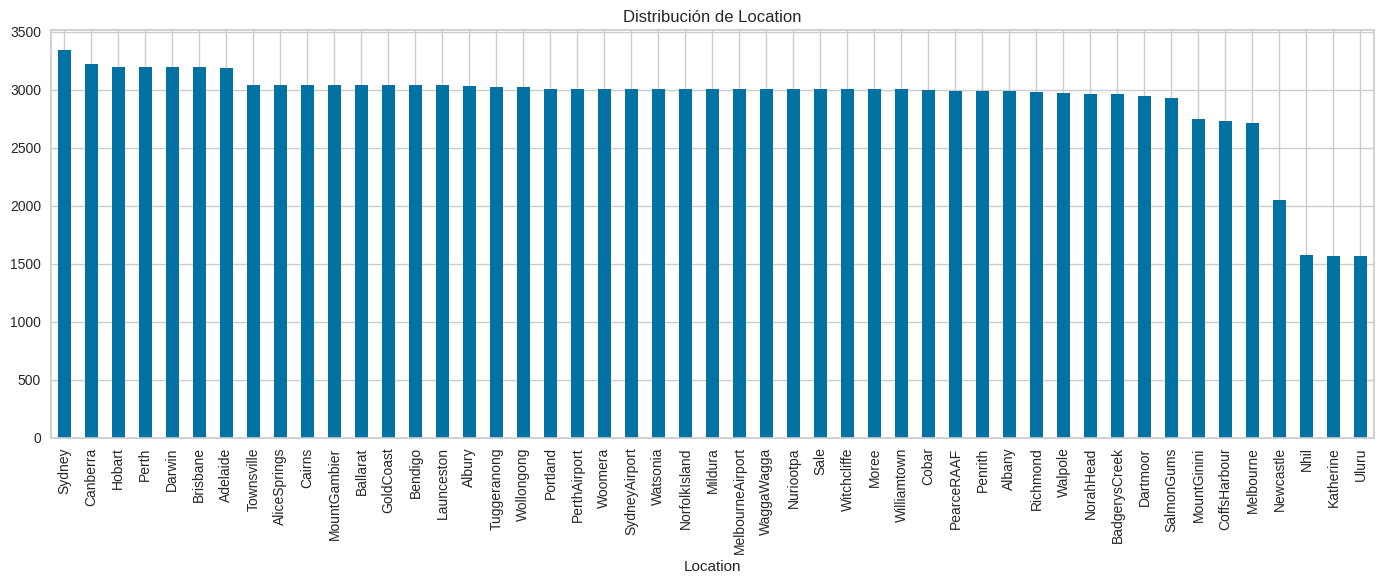

In [25]:
df['Location'].value_counts().plot(kind='bar', figsize=(14, 6))
plt.title("Distribución de Location")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

De ahora en más, trabajaremos con las regiones resultantes, en vez de con cada localidad en particular. La idea es reducir la dimensionalidad en nuestro futuro modelo y además imputar los datos necesarios encontrando estadísticos por región y no generales.

In [26]:
df = df.drop(columns=['Location'])

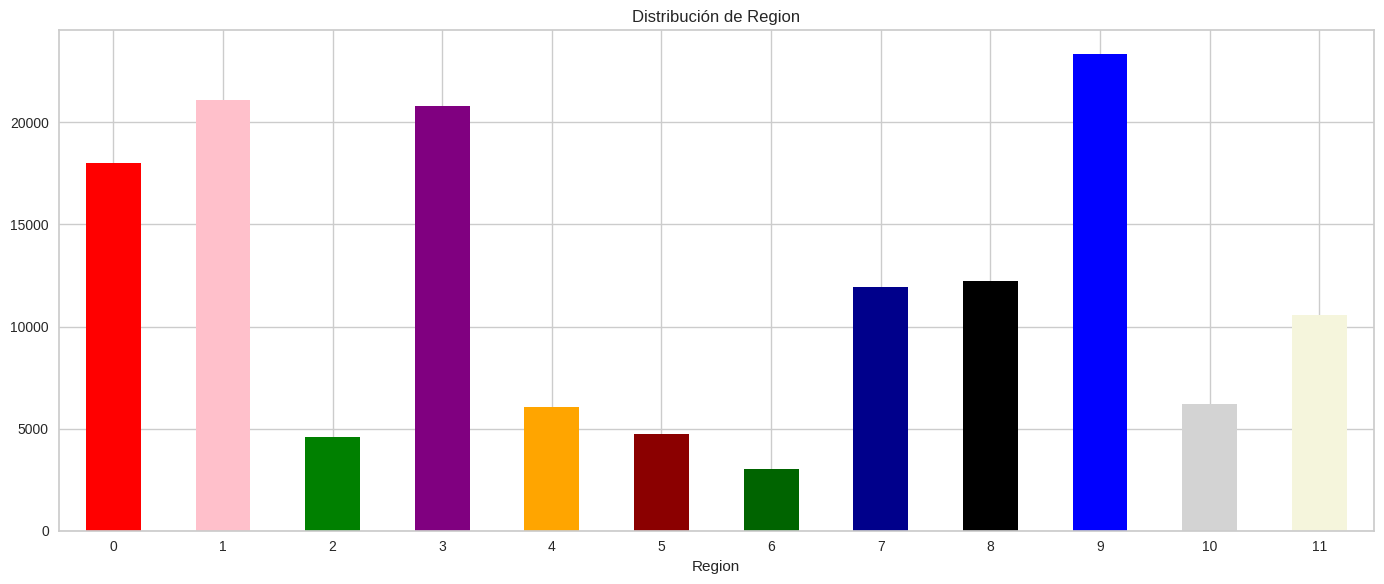

In [27]:
df['Region'].value_counts().sort_index().plot(kind='bar', figsize=(14, 6), color=colores)
plt.title("Distribución de Region")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### WindGustDir, WindDir9am y WindDir3pm

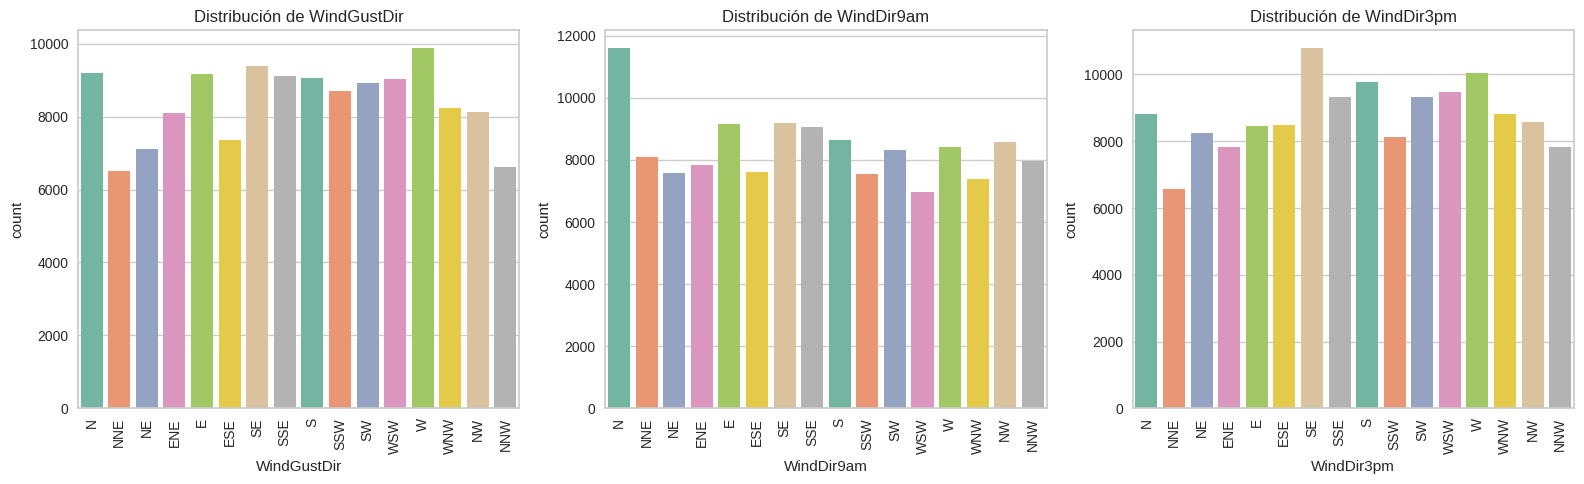

In [28]:
order = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
palette = dict(zip(order, sns.color_palette("Set2", n_colors=16)))
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
# Gráfico WindGustDir
sns.countplot(ax=axes[0], data=df, x="WindGustDir", hue="WindGustDir", palette=palette, order=order, legend=False)
axes[0].set_title("Distribución de WindGustDir")
axes[0].tick_params(axis='x', rotation=90)
# Gráfico WindDir9am
sns.countplot(ax=axes[1], data=df, x="WindDir9am", hue="WindDir9am", palette=palette, order=order, legend=False)
axes[1].set_title("Distribución de WindDir9am")
axes[1].tick_params(axis='x', rotation=90)
# Gráfico WindDir9am
sns.countplot(ax=axes[2], data=df, x="WindDir3pm", hue="WindDir3pm", palette=palette, order=order, legend=False)
axes[2].set_title("Distribución de WindDir3pm")
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

#### RainToday y RainTomorrow

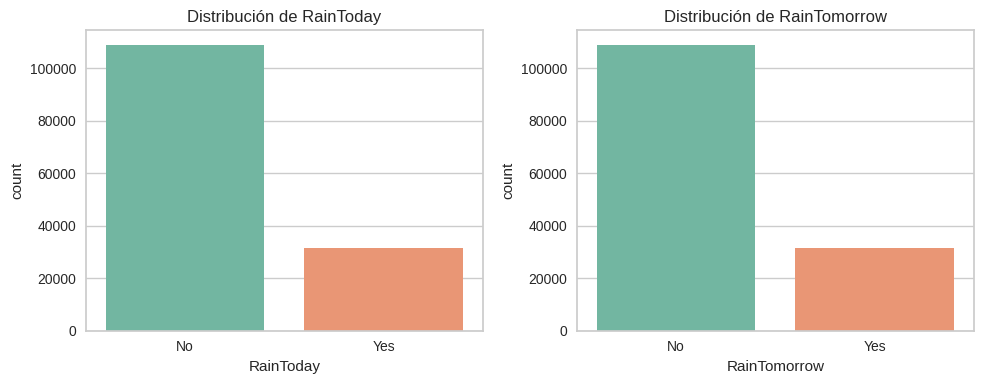

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Gráfico RainToday
sns.countplot(ax=axes[0], data=df, x="RainToday", hue="RainToday", palette="Set2", legend=False)
axes[0].set_title("Distribución de RainToday")
# Gráfico RainTomorrow
sns.countplot(ax=axes[1], data=df, x="RainTomorrow", hue="RainTomorrow", palette="Set2", legend=False)
axes[1].set_title("Distribución de RainTomorrow")

plt.tight_layout()
plt.show()

La distribución de las variables binarias RainToday y RainTomorrow son muy similares, con una gran predominancia a favor de los registros con 'No'. La presencia de cada categoría de nuestra variable objetivo está desbalanceada.




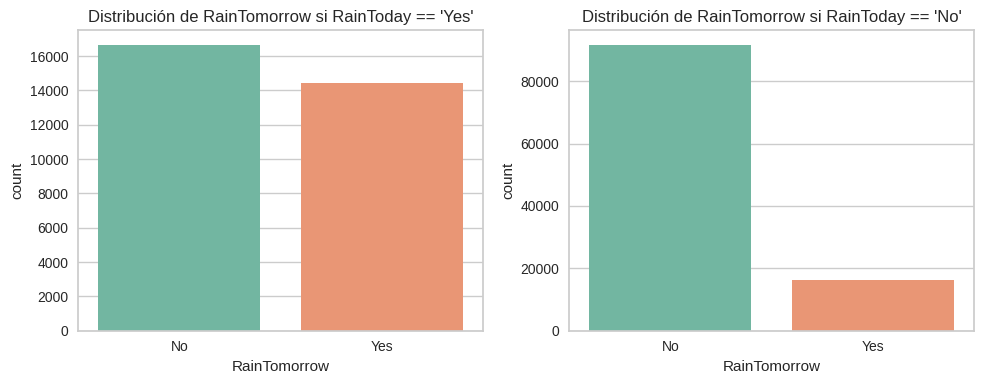

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Gráfico RainTomorrow cuando RainToday == 'Yes'
RainTodayYes = df[df['RainToday'] == 'Yes']
sns.countplot(ax=axes[0], data=RainTodayYes, x="RainTomorrow", hue="RainTomorrow", palette="Set2", legend=False)
axes[0].set_title("Distribución de RainTomorrow si RainToday == 'Yes'")
# Gráfico RainTomorrow cuando RainToday == 'No'
RainTodayNo = df[df['RainToday'] == 'No']
sns.countplot(ax=axes[1], data=RainTodayNo, x="RainTomorrow", hue="RainTomorrow", palette="Set2", legend=False)
axes[1].set_title("Distribución de RainTomorrow si RainToday == 'No'")

plt.tight_layout()
plt.show()

También, la variable RainTomorrow cuenta, a esta altura del análisis, con 2273 registros nulos lo cual representa aproximadamente el 1.59% de nuestros datos. Al tratarse de la variable objetivo, no podremos usar estos registros para entrenar  nuestro modelo, ni tampoco es conveniente imputar valores, por lo que procederemos a eliminarlos.

In [31]:
nan_RainTomorrow = int(df['RainTomorrow'].isna().sum())
print(f"Valores nulos de la variable RainTomorrow: {nan_RainTomorrow}")
print(f"Porcentaje del total de datos que representan: {nan_RainTomorrow/len(df)*100:.2f}%")
# Eliminación
df = df[df['RainTomorrow'].notna()]

Valores nulos de la variable RainTomorrow: 2273
Porcentaje del total de datos que representan: 1.59%


Por último, resolvimos codificar estas variables binarias con el siguiente mapeo:


*   No --> False
*   Yes --> True

No olvidar que en la variable RainToday siguen existiendo datos faltantes los cuales deberemos trabajar previo al entrenamiento.

In [32]:
df["RainTomorrow"] = df["RainTomorrow"].map({"No": False, "Yes": True})
df["RainToday"] = df["RainToday"].map({"No": False, "Yes": True})

In [33]:
df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Region', 'Year', 'Season'],
      dtype='object')

### Variables numéricas

In [34]:
numericas = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
            'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
            'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
print(f"El dataset cuenta con {len(numericas)} variables numéricas. Estas son:\n{numericas}")

El dataset cuenta con 16 variables numéricas. Estas son:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [35]:
print(df[numericas].isnull().sum())

MinTemp            267
MaxTemp            181
Rainfall          1161
Evaporation      59293
Sunshine         66050
WindGustSpeed     7668
WindSpeed9am       376
WindSpeed3pm      1091
Humidity9am       1270
Humidity3pm       2546
Pressure9am      12293
Pressure3pm      12309
Cloud9am         52630
Cloud3pm         55365
Temp9am            424
Temp3pm           1676
dtype: int64


Como podemos comprobar, todas nuestras variables numéricas contienen datos faltantes.

In [36]:
round(df[numericas].describe(), 2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,140131.00,140217.00,139237.00,81105.00,74348.00,132730.00,140022.00,139307.00,139128.00,137852.00,128105.00,128089.00,87768.00,85033.00,139974.00,138722.00
mean,12.19,23.23,2.34,5.47,7.62,39.98,14.03,18.64,68.82,51.48,1017.65,1015.26,4.44,4.50,16.98,21.70
std,6.40,7.12,8.43,4.19,3.78,13.58,8.87,8.80,19.07,20.79,7.11,7.04,2.89,2.72,6.50,6.93
min,-8.50,-4.80,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,980.50,977.10,0.00,0.00,-7.20,-5.40
25%,7.60,17.90,0.00,2.60,4.90,31.00,7.00,13.00,57.00,37.00,1012.90,1010.40,1.00,2.00,12.30,16.60
50%,12.00,22.60,0.00,4.80,8.50,39.00,13.00,19.00,70.00,52.00,1017.60,1015.20,5.00,5.00,16.70,21.10
75%,16.80,28.30,0.80,7.40,10.60,48.00,19.00,24.00,83.00,66.00,1022.40,1020.00,7.00,7.00,21.60,26.40
max,33.90,48.10,371.00,145.00,14.50,135.00,87.00,87.00,100.00,100.00,1041.00,1039.60,9.00,9.00,40.20,46.70


A simple vista, notamos que las variables Rainfall, Evaporation, WindSpeed9am y WindSpeed3pm pueden contener valores atípicos.

#### Distribuciones

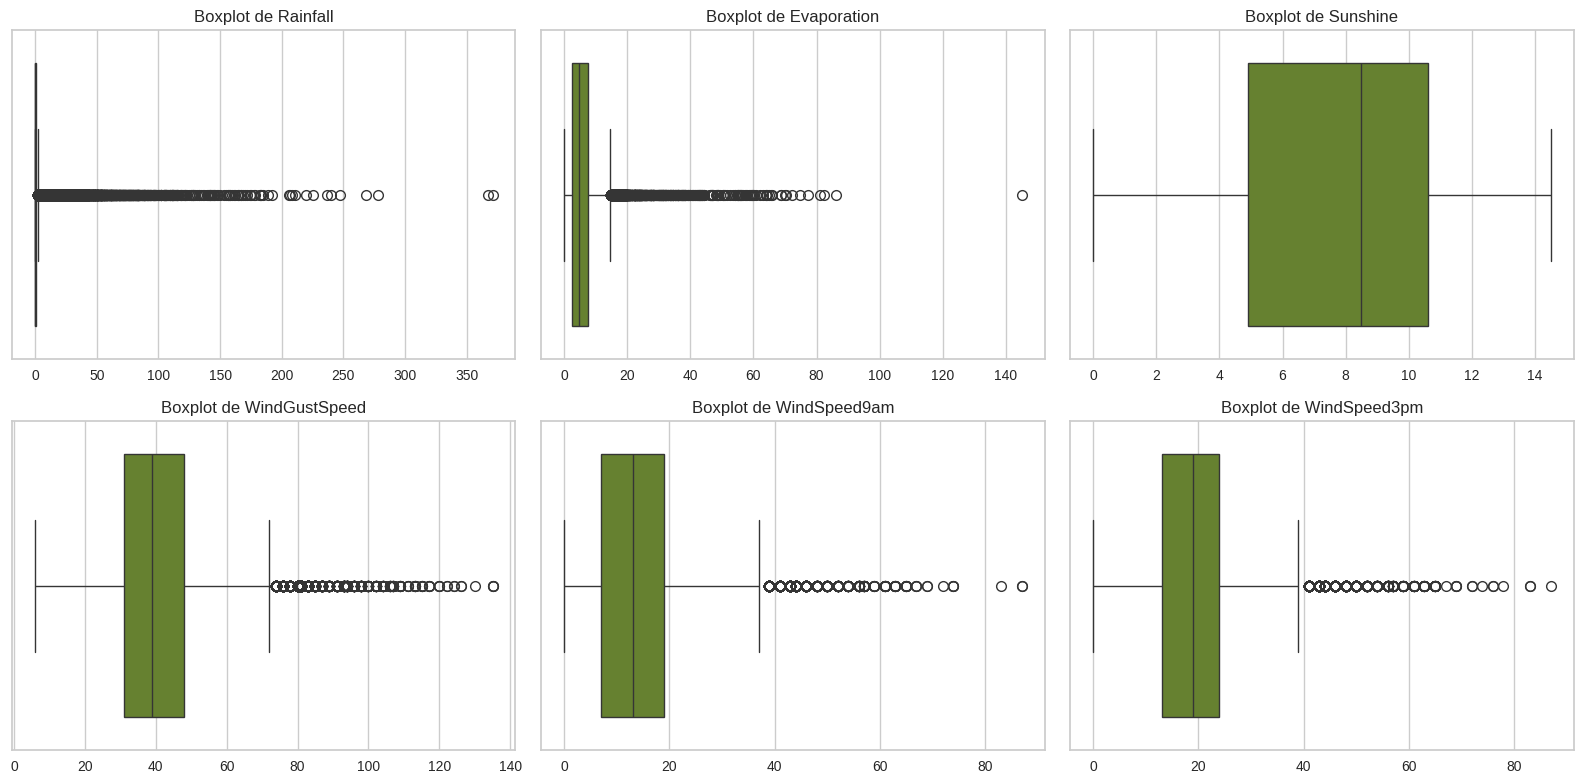

In [37]:
vars1 = ['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']
BoxplotDeLista(vars1)
plt.tight_layout()
plt.show()

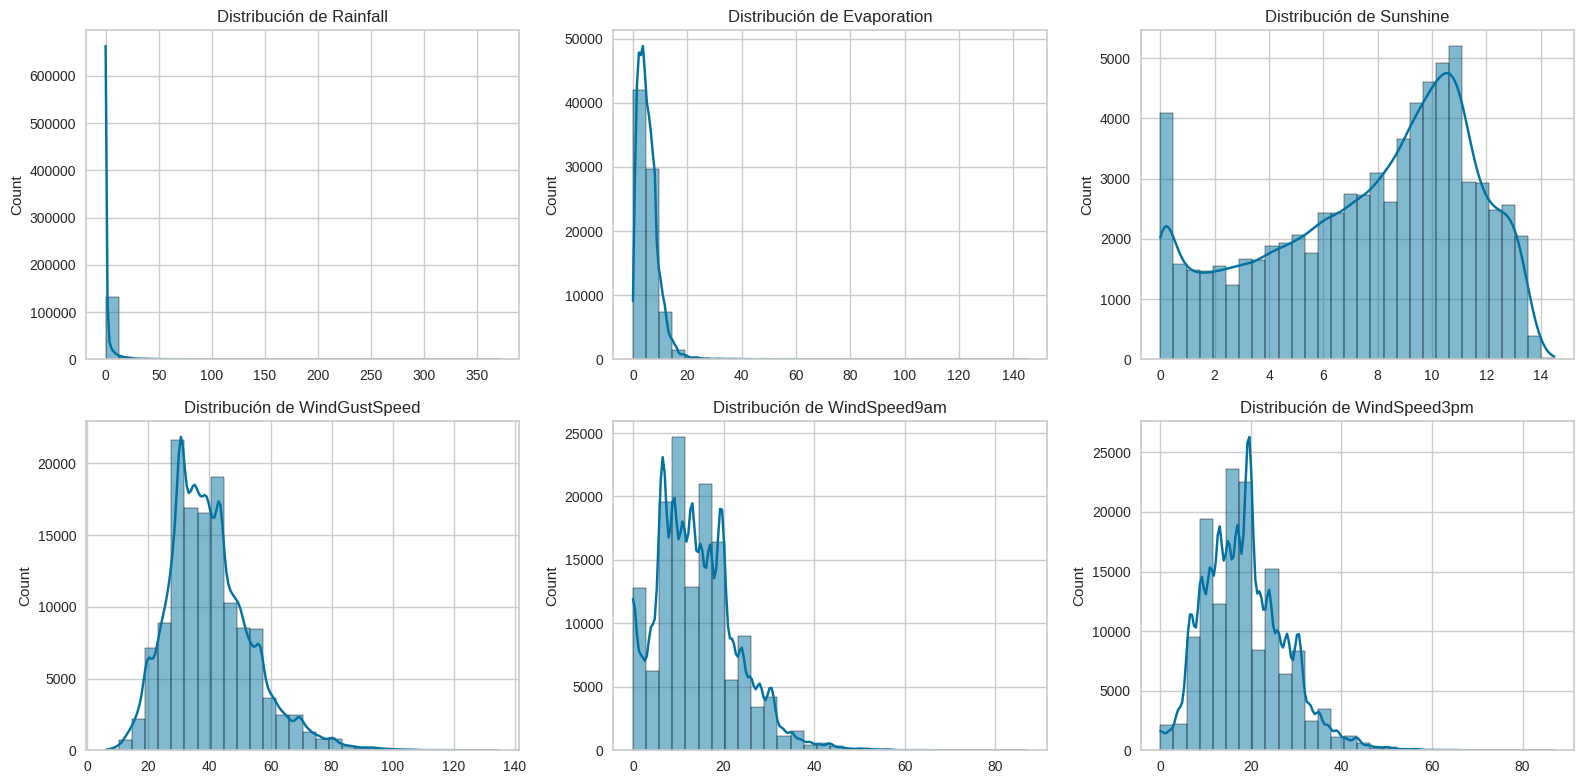

In [38]:
HistDeLista(vars1)
plt.tight_layout()
plt.show()

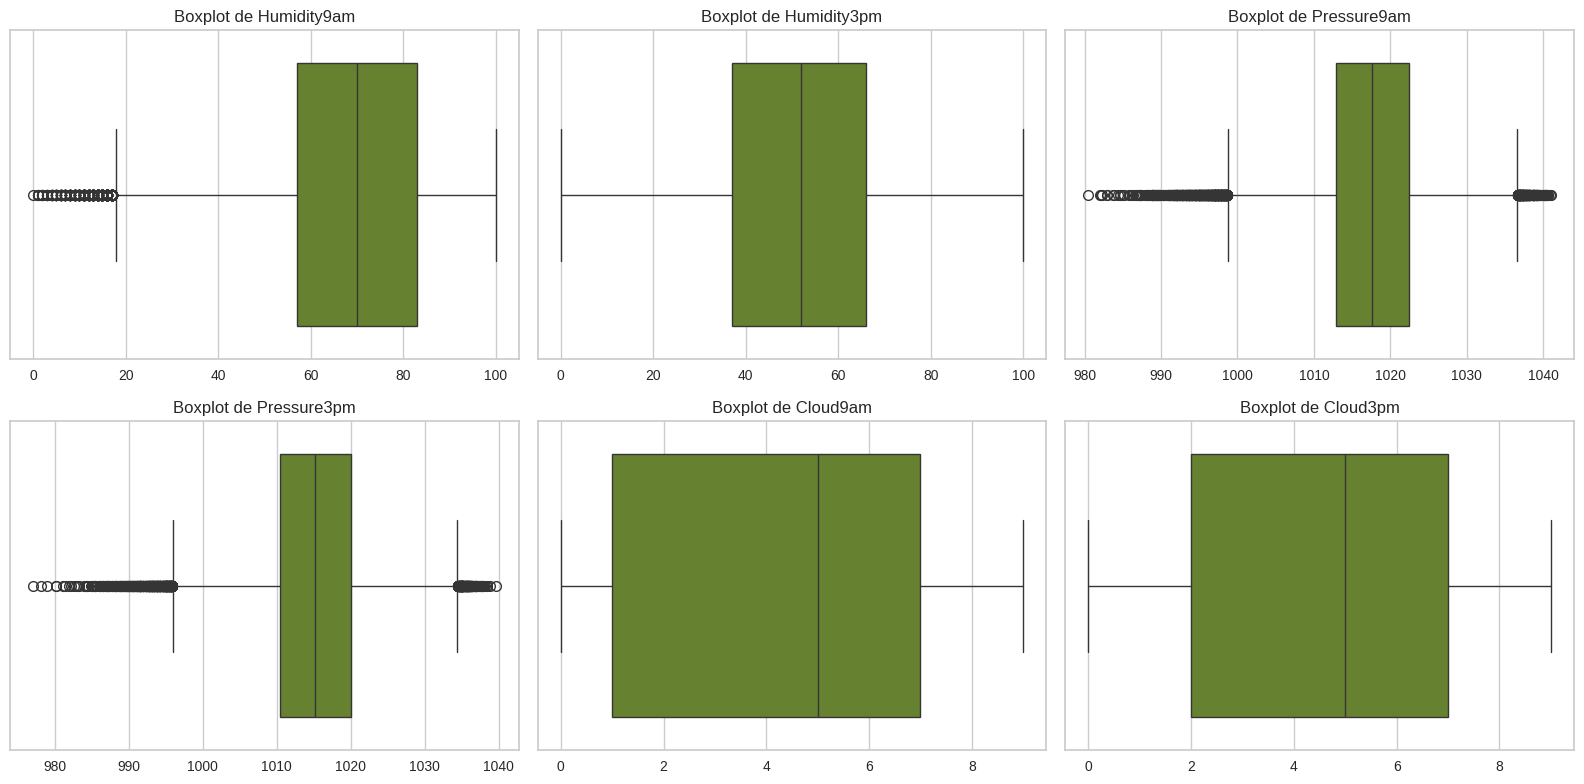

In [39]:
vars2 = ['Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
BoxplotDeLista(vars2)
plt.tight_layout()
plt.show()

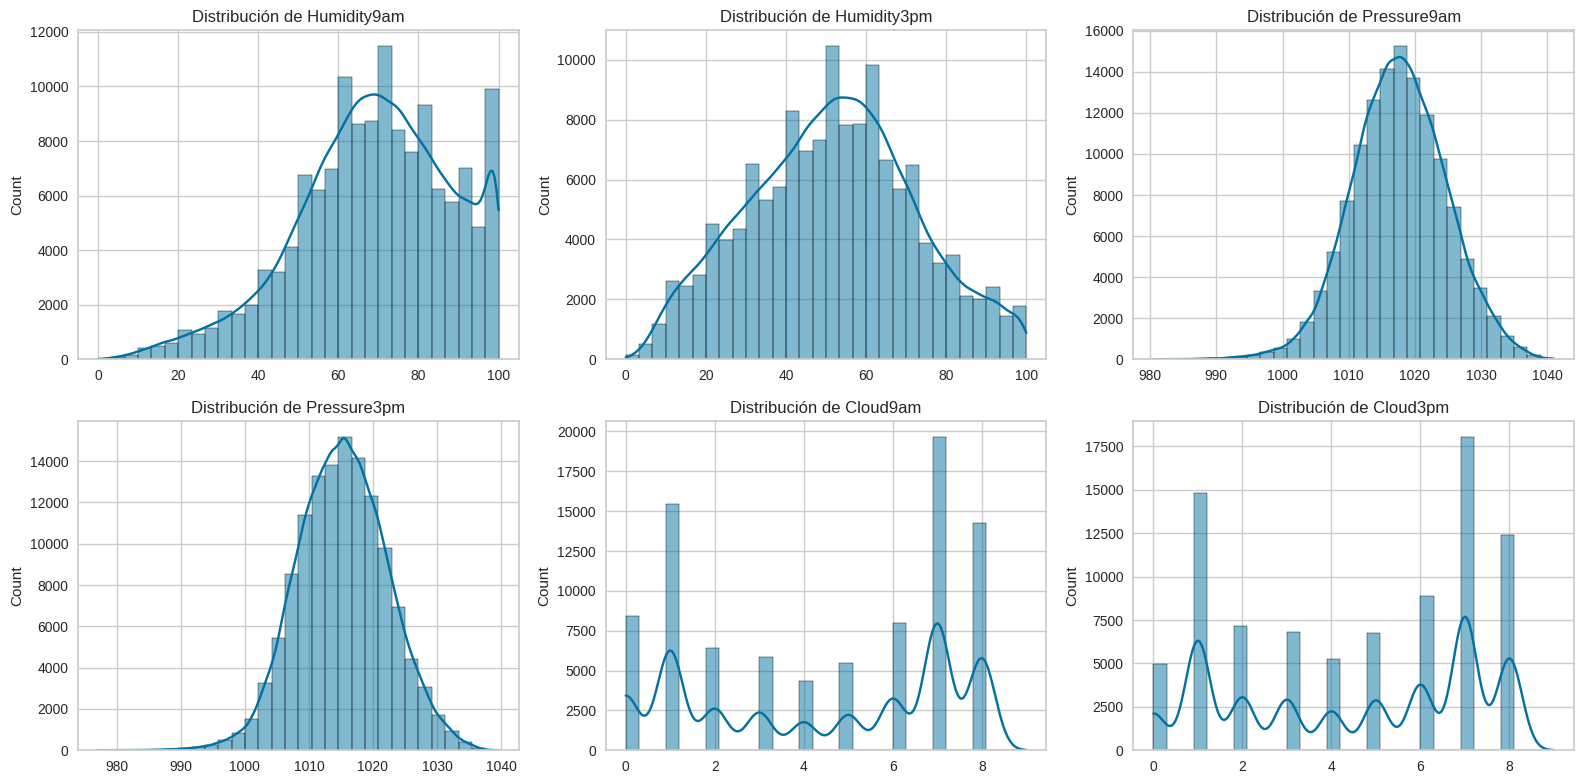

In [40]:
HistDeLista(vars2)
plt.tight_layout()
plt.show()

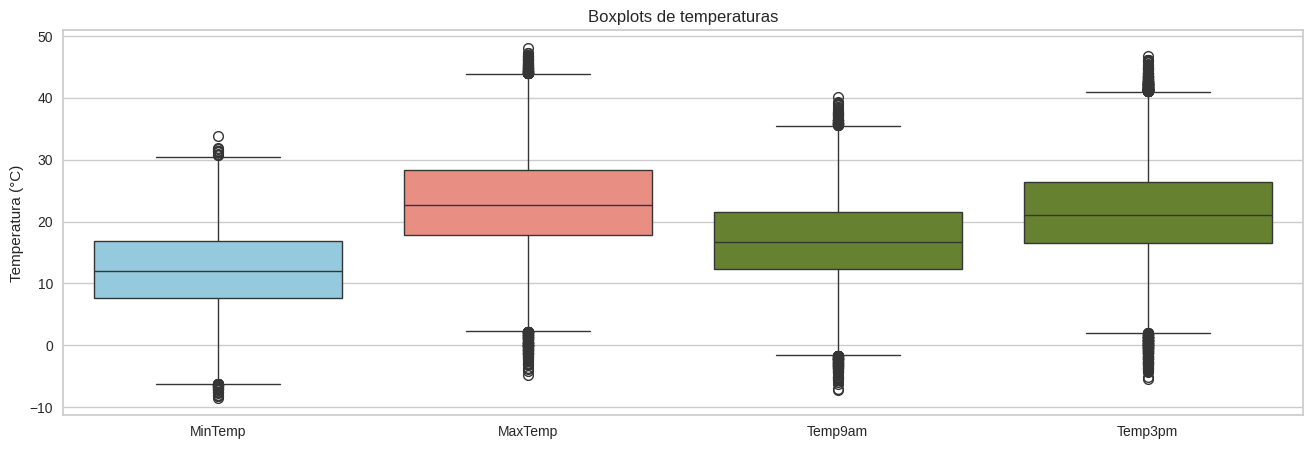

In [41]:
df_melted = df[['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']].melt(var_name='Tipo', value_name='Temperatura')

plt.figure(figsize=(16, 5))
sns.boxplot(x='Tipo', y='Temperatura', data=df_melted, hue='Tipo', palette=['skyblue', 'salmon', 'olivedrab', 'olivedrab'], legend=False)
plt.title('Boxplots de temperaturas')
plt.xlabel(''), plt.ylabel('Temperatura (°C)')
plt.show()

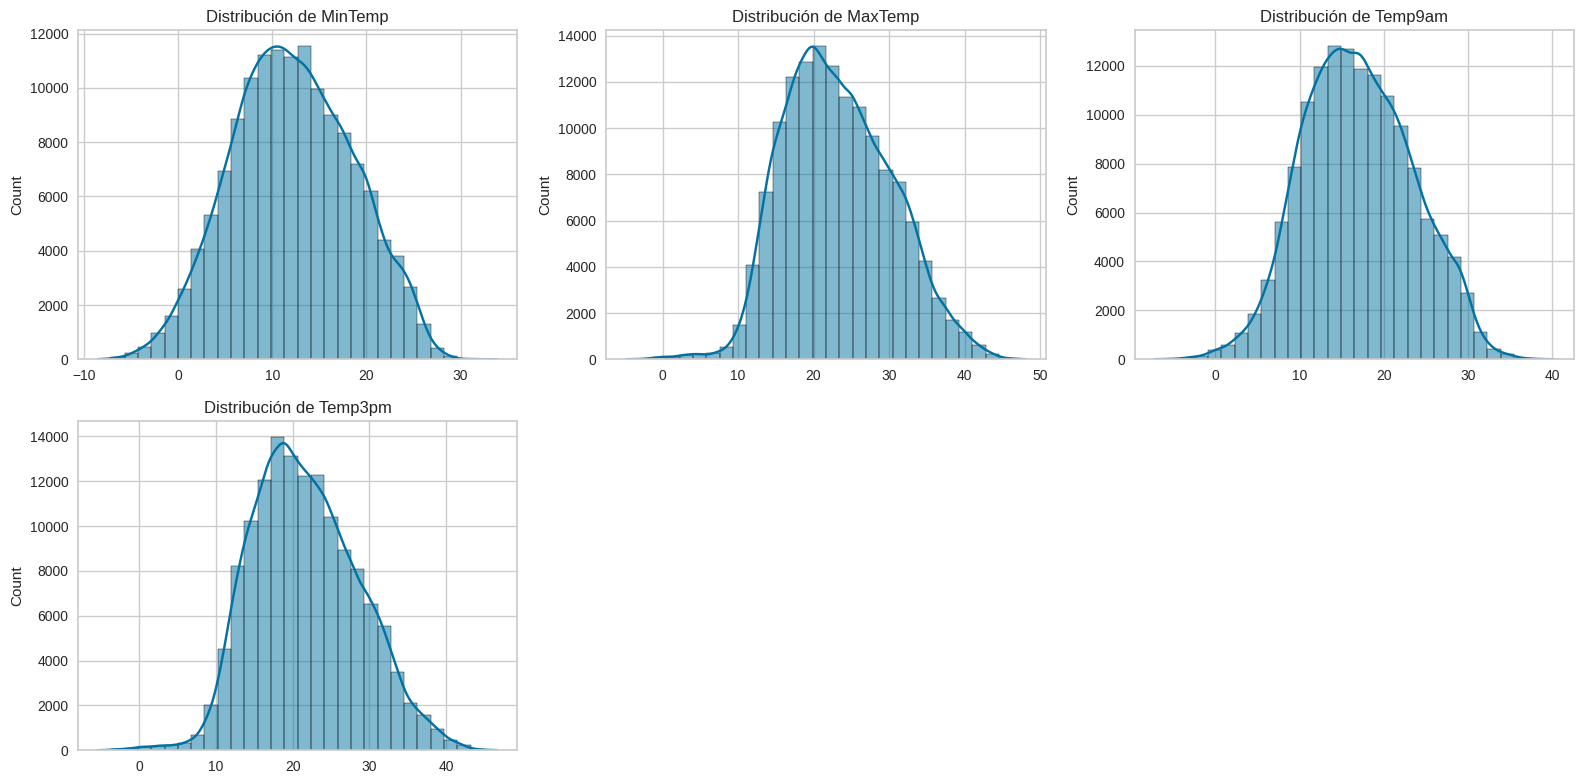

In [42]:
HistDeLista(['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm'])
plt.tight_layout()
plt.show()

#### Outliers

Para limitar los valores outliers de las variables más sesgadas, implementamos umbrales superiores e inferiores. El primero está 3 veces el IQR (rango intercuartílico) por encima del cuantil 75 y el segundo 3 * IQR por debajo del cuantil 25.

In [43]:
# Outliers Rainfall
IQR = df.Rainfall.quantile(0.75) - df.Rainfall.quantile(0.25)
lim_inf = df.Rainfall.quantile(0.25) - (IQR * 3)
lim_sup = df.Rainfall.quantile(0.75) + (IQR * 3)
print(f'Los outliers de la variable Rainfall son los valores menores a {lim_inf} o mayores a {lim_sup}')

Los outliers de la variable Rainfall son los valores menores a -2.4000000000000004 o mayores a 3.2


Para Rainfall, los valores máximos y mínimos son 0.0 y 371.0, así que los outliers serán los valores mayores a 3.2

In [44]:
# Outliers Evaporation
IQR = df.Evaporation.quantile(0.75) - df.Evaporation.quantile(0.25)
lim_inf = df.Evaporation.quantile(0.25) - (IQR * 3)
lim_sup = df.Evaporation.quantile(0.75) + (IQR * 3)
print(f'Los outliers de la variable Evaporation son los valores menores a {lim_inf} o mayores a {lim_sup}')

Los outliers de la variable Evaporation son los valores menores a -11.800000000000002 o mayores a 21.800000000000004


Para Evaporation, los valores máximos y mínimos son 0.0 y 145.0, así que los outliers serán los valores mayores a 21.800000000000004

In [45]:
# Outliers WindSpeed9am
IQR = df.WindSpeed9am.quantile(0.75) - df.WindSpeed9am.quantile(0.25)
lim_inf = df.WindSpeed9am.quantile(0.25) - (IQR * 3)
lim_sup = df.WindSpeed9am.quantile(0.75) + (IQR * 3)
print(f'Los outliers de la variable WindSpeed9am son los valores menores a {lim_inf} o mayores a {lim_sup}')

Los outliers de la variable WindSpeed9am son los valores menores a -29.0 o mayores a 55.0


Para WindSpeed9am, los valores máximos y mínimos son 0.0 y 87.0, así que los outliers serán los valores mayores a 55.0

In [46]:
# Outliers WindSpeed3pm
IQR = df.WindSpeed3pm.quantile(0.75) - df.WindSpeed3pm.quantile(0.25)
lim_inf = df.WindSpeed3pm.quantile(0.25) - (IQR * 3)
lim_sup = df.WindSpeed3pm.quantile(0.75) + (IQR * 3)
print(f'Los outliers de la variable WindSpeed3pm son los valores menores a {lim_inf} o mayores a {lim_sup}')

Los outliers de la variable WindSpeed3pm son los valores menores a -20.0 o mayores a 57.0


Para WindSpeed3pm, los valores máximos y mínimos son 0.0 y 87.0, así que los outliers serán los valores mayores a 57.0

#### Matriz de correlación

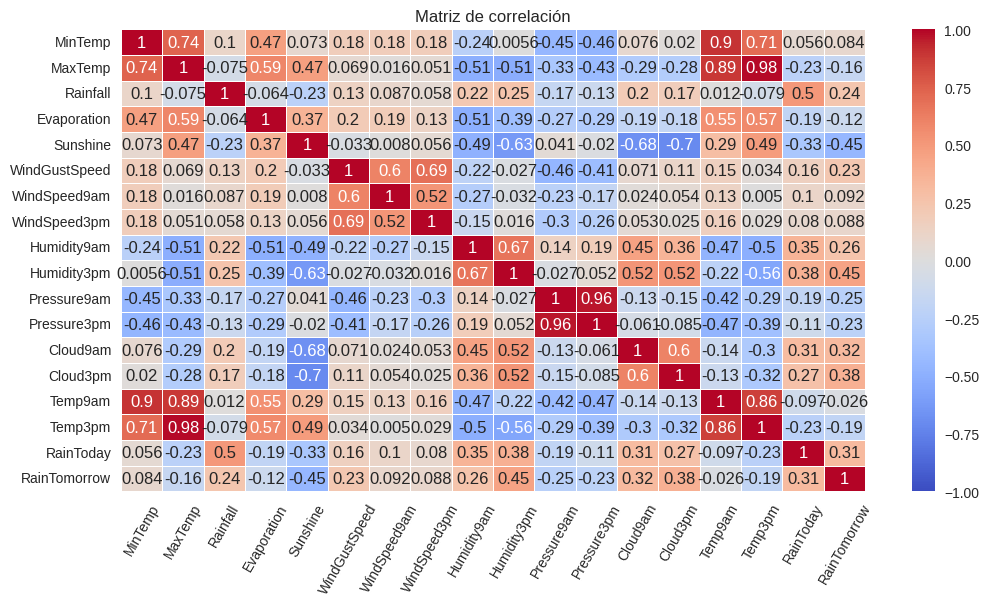

In [47]:
plt.figure(figsize=(12, 6))
sns.heatmap(df[numericas + ["RainToday", "RainTomorrow"]].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='coolwarm')
plt.title("Matriz de correlación"), plt.xticks(rotation=60)
plt.show()

## División del dataset en conjuntos de entrenamiento y prueba

In [48]:
X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Outliers

Para mitigar el impacto de los valores atípicos de las variables numéricas Rainfall, Evaporation, WindSpeed9am y Windspeed3pm; aplicamos una técnica de winsorización por el extremo superior. Esta consiste en limitar los valores máximos a un umbral previamente definido, reemplazando los valores que lo superan por el propio umbral.

In [49]:
for df1 in [X_train, X_test]:
    df1['Rainfall'] = np.where(df1['Rainfall'] > 3.2, 3.2, df1['Rainfall'])
    df1['Evaporation'] = np.where(df1['Evaporation'] > 21.8, 21.8, df1['Evaporation'])
    df1['WindSpeed9am'] = np.where(df1['WindSpeed9am'] > 55, 55, df1['WindSpeed9am'])
    df1['WindSpeed3pm'] = np.where(df1['WindSpeed3pm'] > 57, 57, df1['WindSpeed3pm'])

In [50]:
round(X_train.describe(), 2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Region,Year
count,112114.00,112170.00,111381.00,64896.00,59369.00,106169.00,112015.00,111430.00,111294.0,110249.00,102434.00,102423.00,70185.00,67995.00,111976.00,110952.00,112318.00,112318.00
mean,12.18,23.24,0.68,5.42,7.62,39.97,14.02,18.63,68.8,51.45,1017.66,1015.26,4.44,4.50,16.99,21.70,5.11,2012.76
std,6.41,7.12,1.19,3.71,3.79,13.59,8.85,8.78,19.1,20.81,7.11,7.04,2.89,2.73,6.50,6.93,3.73,2.54
min,-8.50,-4.80,0.00,0.00,0.00,7.00,0.00,0.00,0.0,0.00,980.50,977.10,0.00,0.00,-7.20,-5.40,0.00,2007.00
25%,7.60,17.90,0.00,2.60,4.80,31.00,7.00,13.00,57.0,37.00,1013.00,1010.50,1.00,2.00,12.30,16.60,1.00,2011.00
50%,12.00,22.60,0.00,4.80,8.40,39.00,13.00,19.00,70.0,52.00,1017.60,1015.30,5.00,5.00,16.70,21.10,5.00,2013.00
75%,16.80,28.30,0.80,7.40,10.60,48.00,19.00,24.00,83.0,66.00,1022.40,1020.00,7.00,7.00,21.60,26.40,9.00,2015.00
max,33.90,48.10,3.20,21.80,14.50,135.00,55.00,57.00,100.0,100.00,1041.00,1039.60,9.00,9.00,40.20,46.70,11.00,2017.00


## Imputación de datos faltantes y escalado de datos

### Variables numéricas

En primer lugar, imputaremos los datos faltantes de las variables numéricas. Tras observar las distribuciones de las variables en el análisis descriptivo previo, convenimos en realizar dos tipos de imputaciones.

*   Por un lado, en las variables con distribución cercana a la normal, optamos por imputar calculando la mediana por región. Optamos por la mediana debido a su robustez frente a valores atípicos. A su vez, la decisión de calcularla por región fue tomada buscando preservar patrones locales relevantes que podrían verse sesgados si se empleara una mediana global.
*   Por otro lado, realizamos imputaciones con KNN por región en variables con varias modas o distribuciones sesgadas. Debido al alto coste computacional de este método, lo realizamos únicamente en las variables en las que lo creímos estrictamente necesario, como 'Evaporation', 'Cloud9am', 'Cloud3pm'.



#### Imputar por mediana de cada región

In [51]:
# Variables a imputar por la mediana de cada región
variables_mediana = ['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

In [52]:
for df2 in [X_train, X_test]:
  for variable in variables_mediana:
    # Calcular la mediana por región en X_train
    mediana_region = X_train.groupby('Region')[variable].median()
    # Imputar los nulos con la mediana correspondiente a su región
    df2[variable] = df2.apply(
      lambda row: mediana_region[row['Region']] if pd.isnull(row[variable]) else row[variable],
      axis=1
    )

#### Escalado de datos

Debido a que KNN es un método basado en distancias, es fundamental escalar los datos antes de utilizarlo para imputar. En caso contrario, las variables con valores grandes podrían dominar la distancia, afectando negativamente la imputación. Por esto, empleamos el escalado de datos en este punto del trabajo.

In [53]:
scaler = StandardScaler().set_output(transform="pandas")
X_train[numericas] = scaler.fit_transform(X_train[numericas])
X_test[numericas] = scaler.transform(X_test[numericas])

In [54]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Region,Year,Season
94054,1.985336,1.204149,-0.570659,-0.004288,0.049512,E,0.082694,SE,E,-0.115057,...,-1.721494,-1.786209,-0.151090,0.915964,1.928031,1.307733,False,4,2011,Summer
73203,-0.544614,0.093366,-0.232823,NaN,0.362888,SSW,-0.219962,S,S,0.676775,...,0.354361,0.549101,NaN,NaN,-0.397078,0.124270,False,8,2016,Summer
55168,0.439255,1.372876,-0.570659,NaN,-0.437963,SW,-0.068634,SW,SW,-1.359364,...,-1.677327,-1.265599,-1.536409,NaN,1.512283,1.322165,False,3,2009,Summer
113203,0.064448,-0.778388,1.625272,NaN,0.397708,WSW,0.461015,W,WNW,-0.115057,...,-0.028421,0.192111,NaN,NaN,-0.273894,-0.900436,True,1,2013,Winter
121553,1.017083,2.216508,-0.570659,1.774716,1.581576,E,0.082694,ESE,ESE,0.111181,...,-1.147322,-1.399470,-1.190079,-0.551655,1.373700,2.390169,False,1,2011,Summer


In [55]:
X_test.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Region,Year,Season
102033,0.548574,-0.033179,0.442848,0.211349,-0.507603,SW,-0.219962,SSW,SSW,0.676775,...,-0.411202,0.102863,0.887899,1.282869,0.265039,-0.265407,True,11,2016,Summer
83909,0.205000,1.218210,-0.570659,NaN,-0.507603,SE,-0.673947,ENE,SE,-1.133126,...,-0.484814,-0.313625,NaN,NaN,0.218845,1.250003,False,11,2017,Autumn
31548,0.532957,-0.300329,-0.570659,0.480895,-1.412913,SSE,1.747305,SSW,SSE,0.676775,...,-0.499537,-0.045883,NaN,NaN,0.449816,-0.784976,False,9,2011,Summer
129578,-0.497764,-1.214264,2.132026,NaN,0.397708,W,1.898633,W,WSW,1.129251,...,-0.175644,0.578850,NaN,NaN,-0.566457,-1.347843,True,1,2016,Spring
99104,-0.247892,-0.258147,-0.232823,NaN,0.362888,NNW,-1.203595,NNE,NNW,-0.567532,...,0.928534,0.831718,NaN,NaN,-0.381680,-0.106650,False,8,2016,Autumn


#### Imputar con KNN

In [56]:
# Variables a imputar con KNN por región
variables_knn = ['Evaporation', 'Cloud9am', 'Cloud3pm']

In [57]:
# Imputar con KNN por región en X_train y aplicar el mismo modelo en X_test
for region in X_train['Region'].unique():
    # Filtrar por región
    train_region = X_train[X_train['Region'] == region]
    test_region = X_test[X_test['Region'] == region]
    # Crear el imputador y ajustarlo al train de la región
    imputer = KNNImputer()
    train_imputed = imputer.fit_transform(train_region[variables_knn])
    # Aplicar al test de la región
    test_imputed = imputer.transform(test_region[variables_knn])
    # Asignar los datos imputados
    X_train.loc[train_region.index, variables_knn] = train_imputed
    X_test.loc[test_region.index, variables_knn] = test_imputed

In [58]:
print(X_train[numericas].isnull().sum())

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64


In [59]:
print(X_test[numericas].isnull().sum())

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64


#### Distribuciones

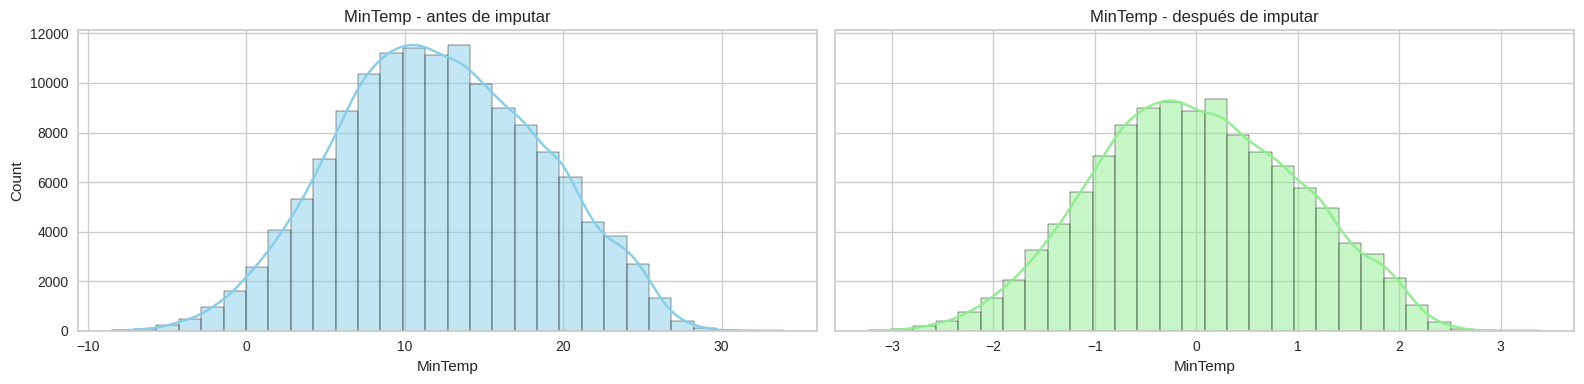

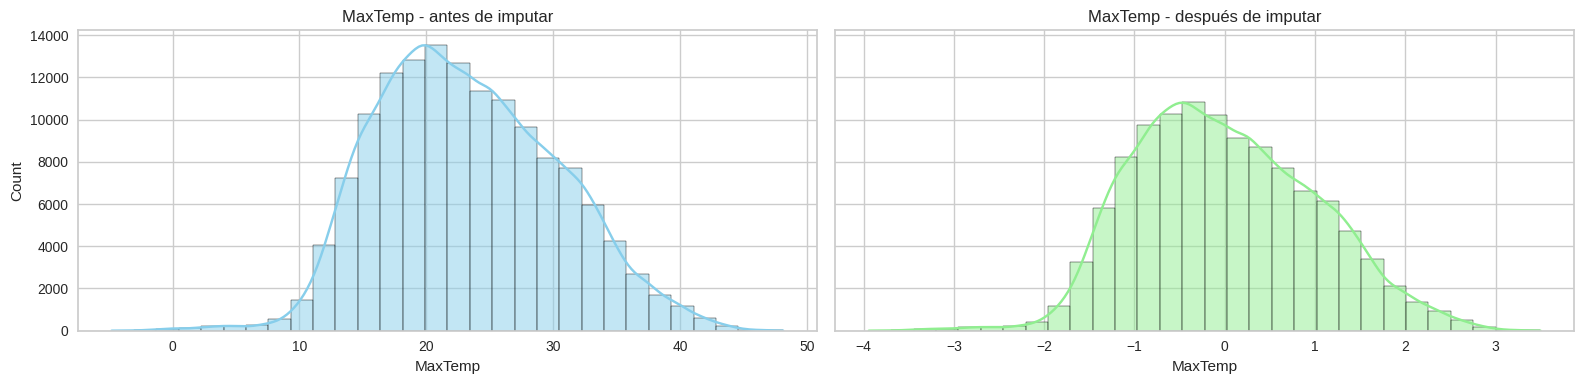

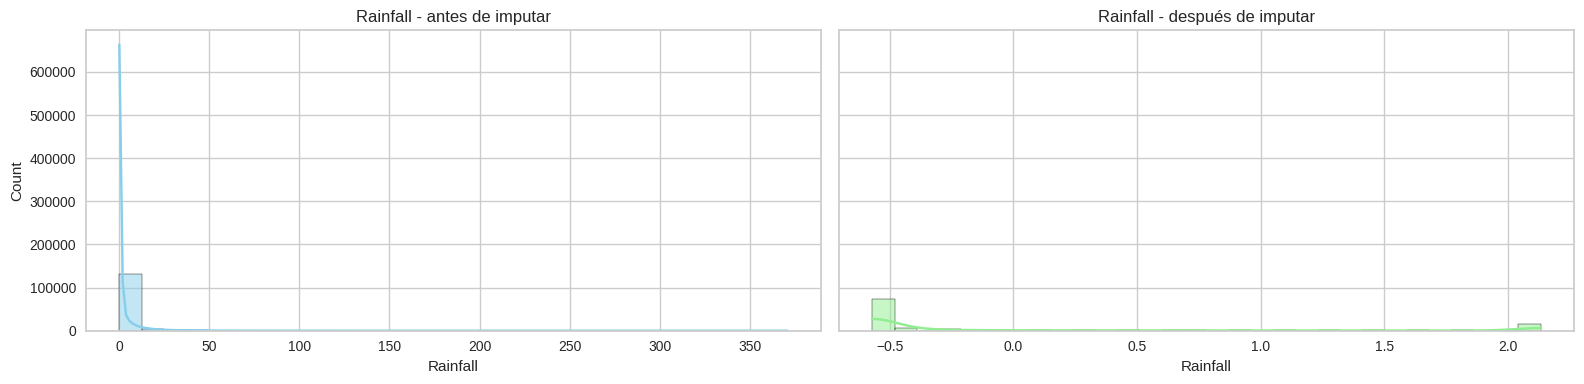

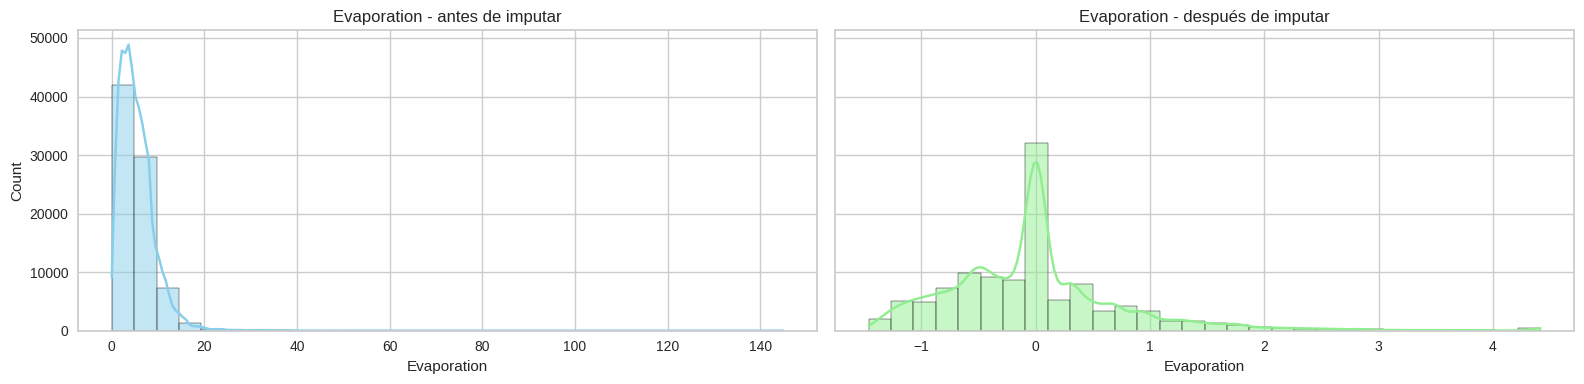

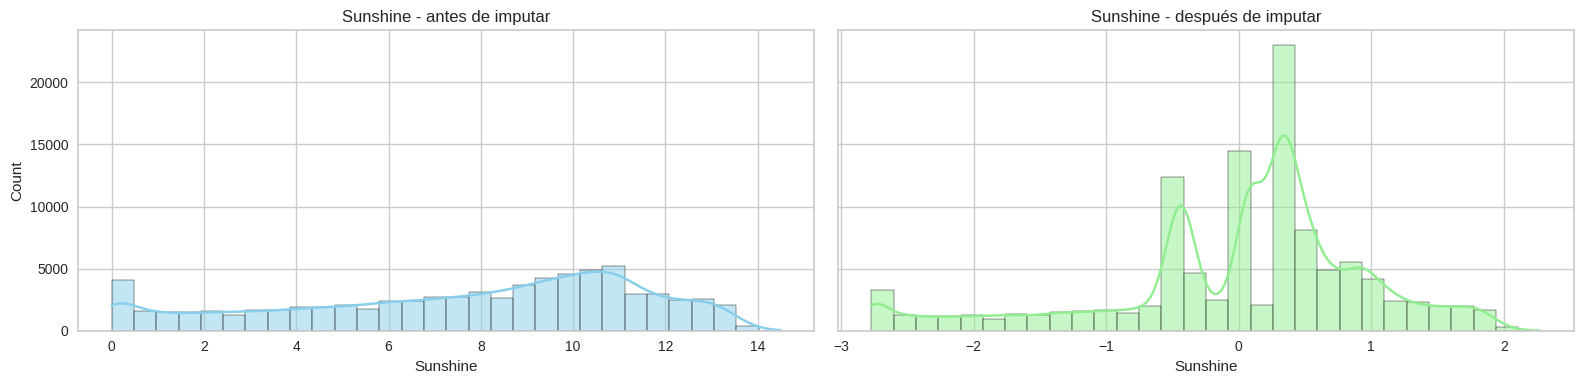

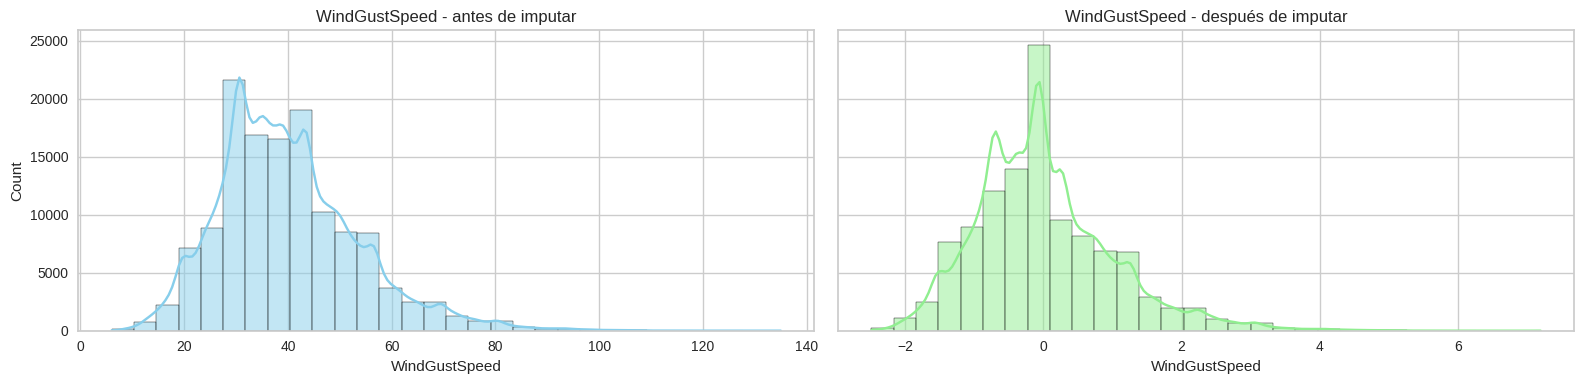

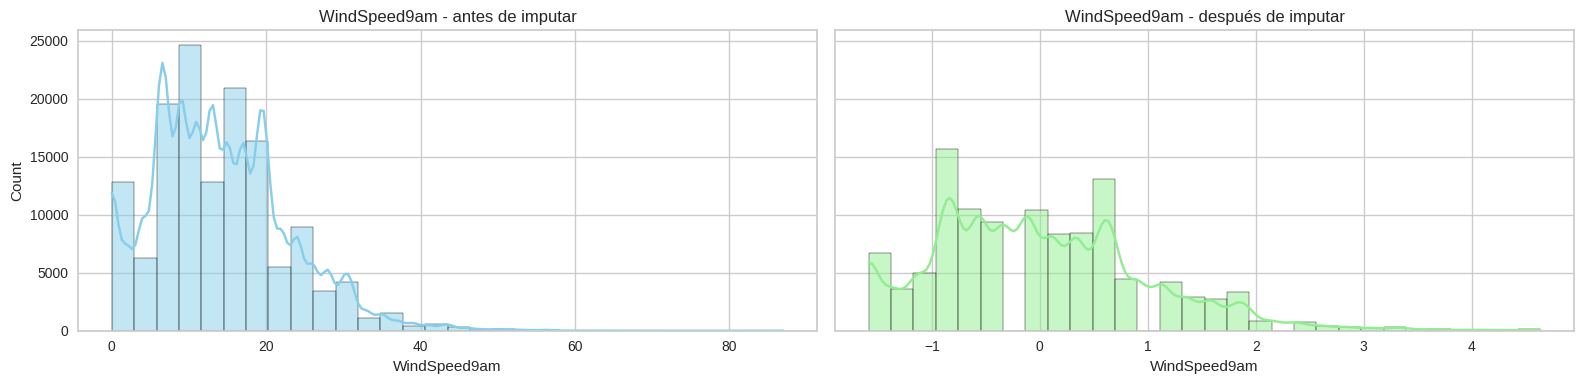

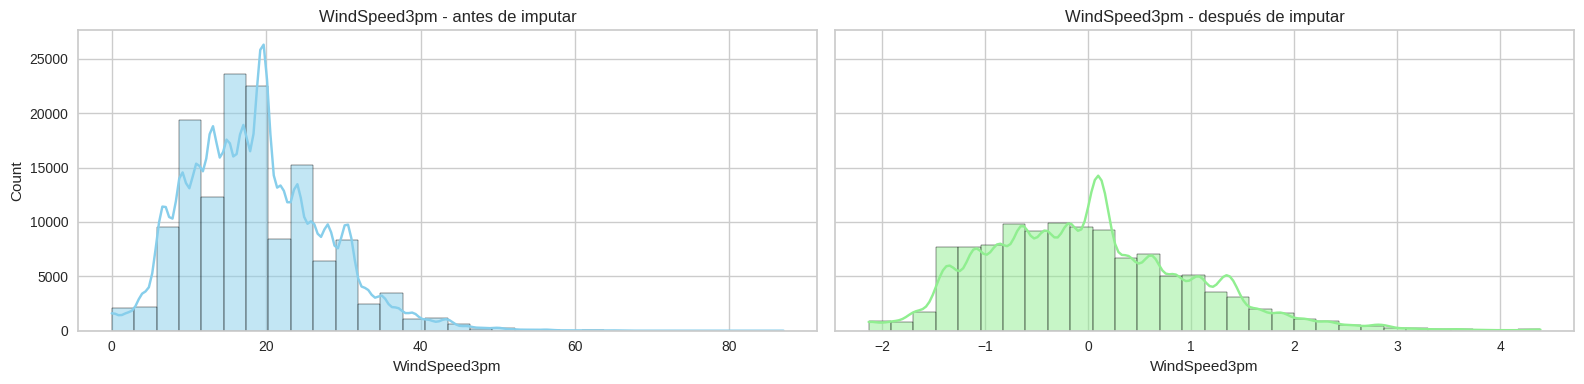

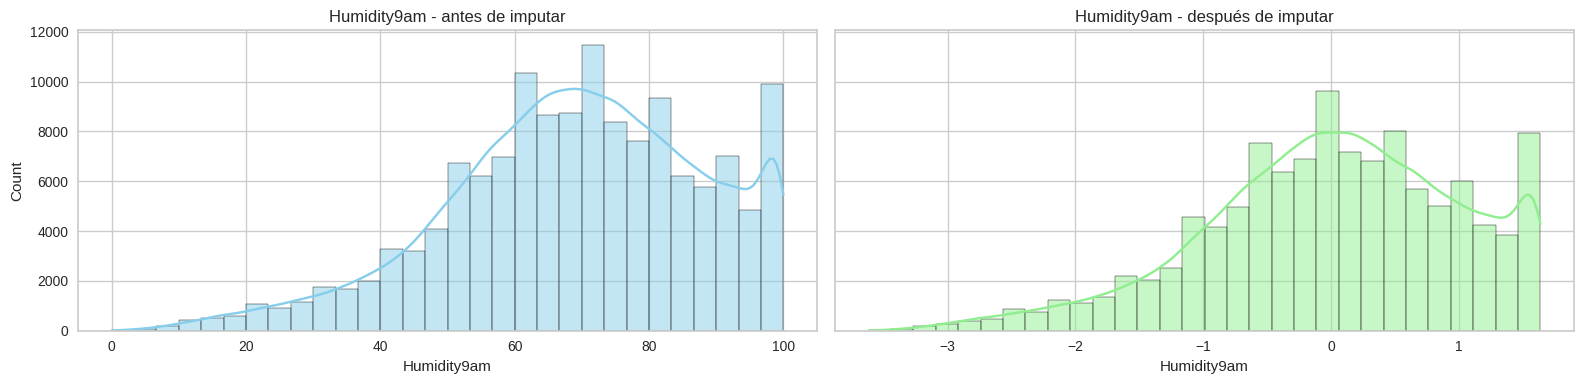

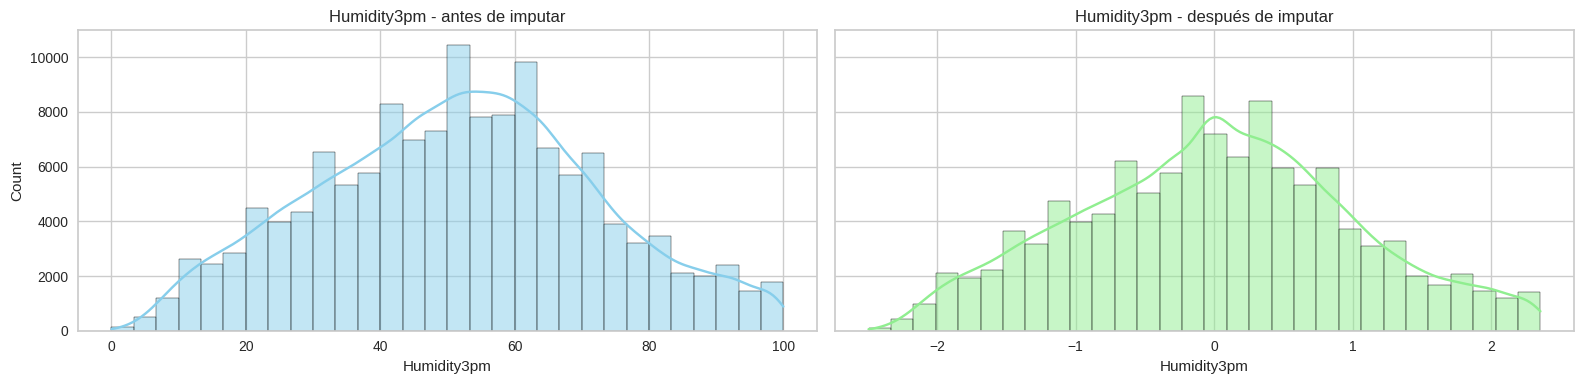

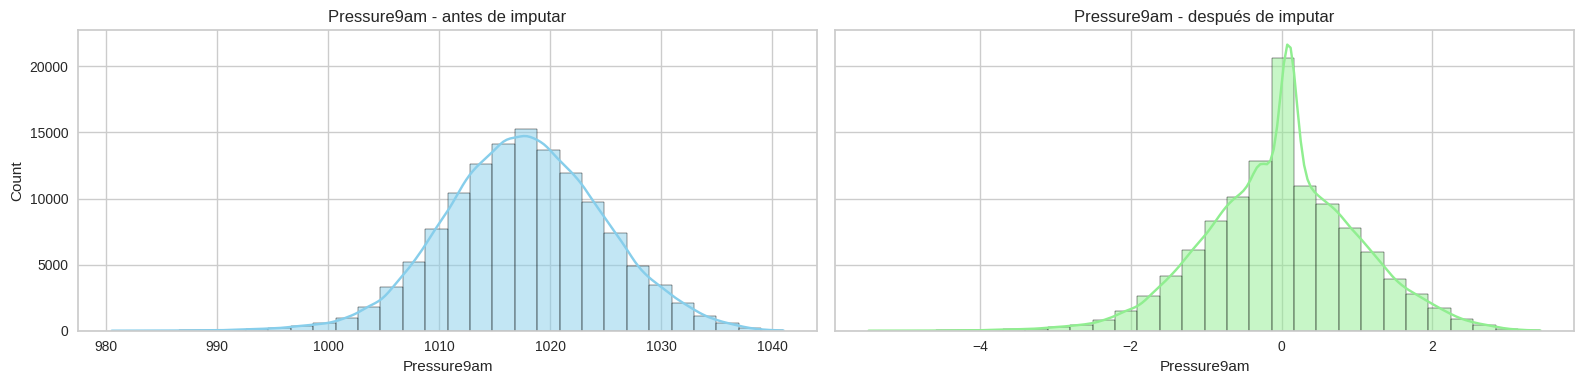

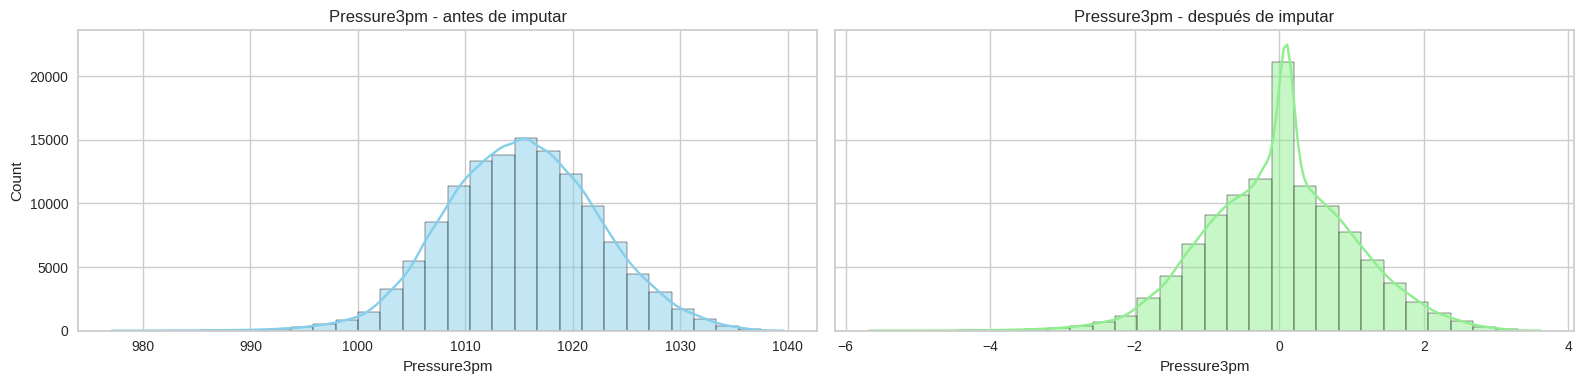

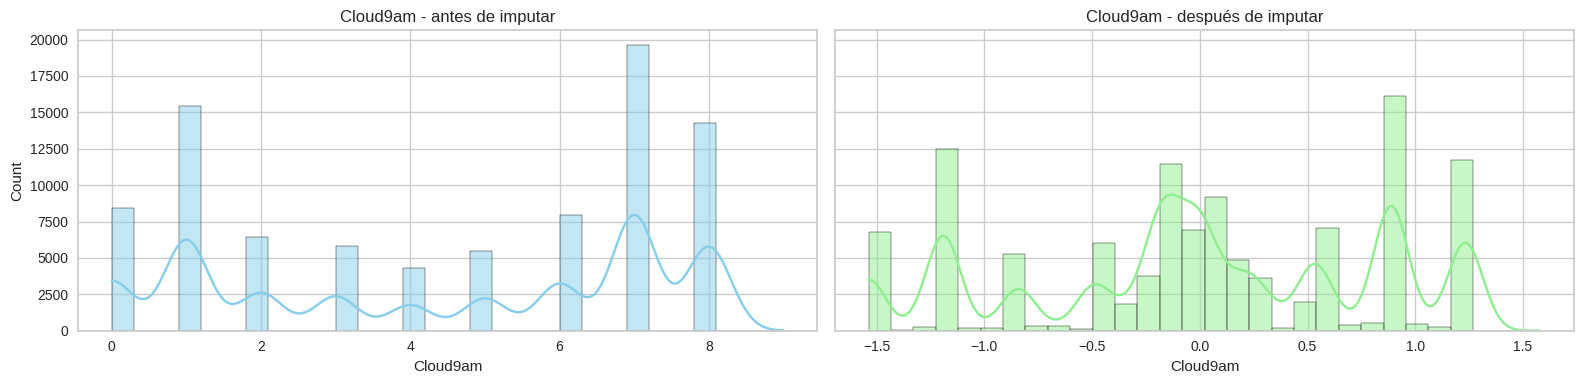

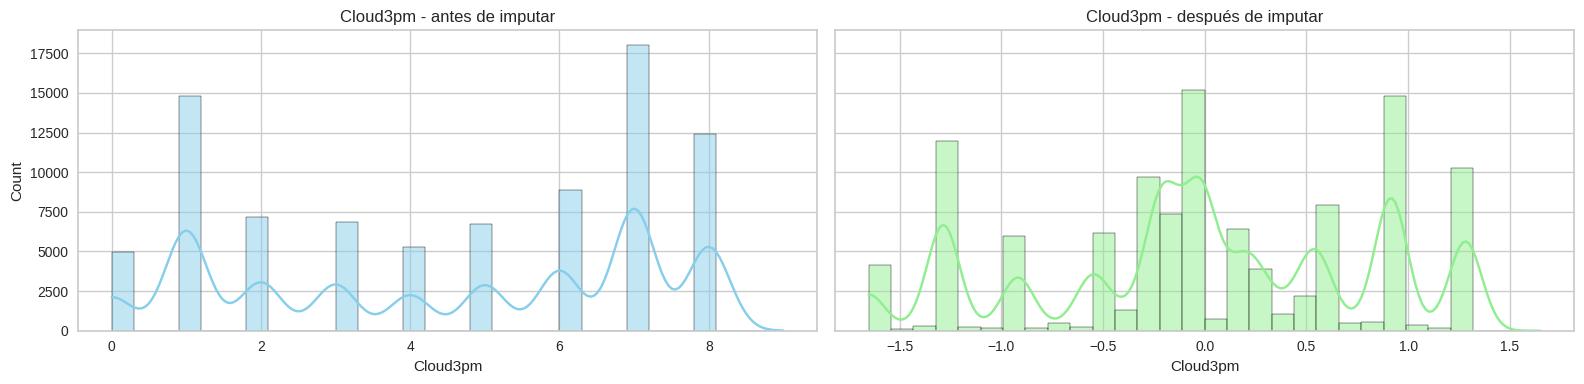

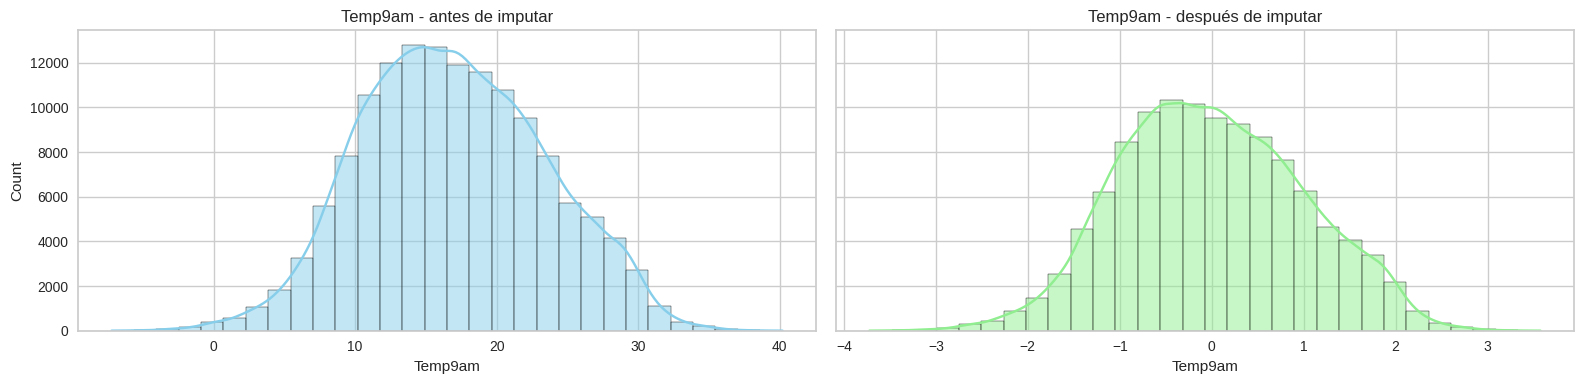

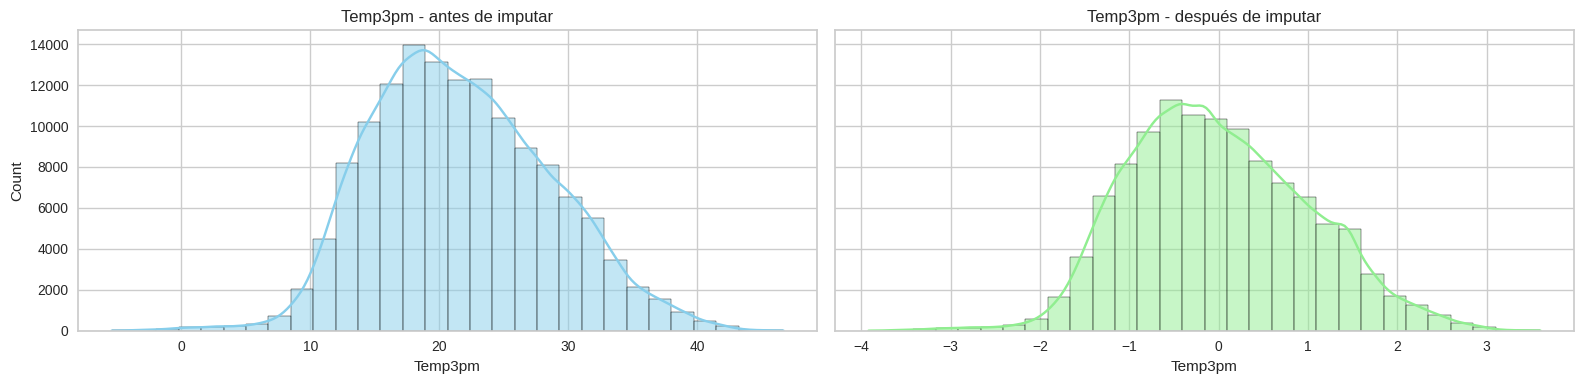

In [60]:
for var in numericas:
    fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
    # Antes de imputar
    sns.histplot(df[var], kde=True, bins=30, ax=axes[0], color='skyblue')
    axes[0].set_title(f'{var} - antes de imputar')
    # Después de imputar
    sns.histplot(X_train[var], kde=True, bins=30, ax=axes[1], color='lightgreen')
    axes[1].set_title(f'{var} - después de imputar')

    plt.tight_layout()
    plt.show()

### Variables categóricas

Ahora, imputaremos los datos faltantes de las variables categóricas utilizando la moda por región de cada una en el conjunto de entrenamiento.

In [61]:
for df in [X_train, X_test]:
  for variable in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']:
    moda_region = X_train.groupby('Region')[variable].agg(lambda x: x.mode().iloc[0])
    df[variable] = df.apply(
      lambda row: moda_region[row['Region']] if pd.isnull(row[variable]) else row[variable],
      axis=1
    )

In [62]:
print(X_train.isnull().sum())

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Region           0
Year             0
Season           0
dtype: int64


In [63]:
print(X_test.isnull().sum())

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Region           0
Year             0
Season           0
dtype: int64


## Codificación de variables categóricas

Realizamos one-hot enconding para cada una de las 12 regiones de la variable Region. El parámetro *drop_first=True* elimina una de las categorías de la variable para evitar colinealidad.

In [64]:
RegionDummiesTrain = pd.get_dummies(X_train["Region"], prefix="Region", drop_first=True)
X_train = pd.concat([X_train.drop(columns="Region"), RegionDummiesTrain], axis=1)

RegionDummiesTest = pd.get_dummies(X_test["Region"], prefix="Region", drop_first=True)
X_test = pd.concat([X_test.drop(columns="Region"), RegionDummiesTest], axis=1)

RegionDummiesTrain.head()

,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,Region_11
94054,False,False,False,True,False,False,False,False,False,False,False
73203,False,False,False,False,False,False,False,True,False,False,False
55168,False,False,True,False,False,False,False,False,False,False,False
113203,True,False,False,False,False,False,False,False,False,False,False
121553,True,False,False,False,False,False,False,False,False,False,False


De la misma manera, continuamos realizando la codificación one-hot de las variables WindGustDir, WindDir9am, WindDir3pm y Month.

In [65]:
WindGustDirDummiesTrain = pd.get_dummies(X_train["WindGustDir"], prefix="WindGustDir", drop_first=True)
X_train = pd.concat([X_train.drop(columns="WindGustDir"), WindGustDirDummiesTrain], axis=1)

WindGustDirDummiesTest = pd.get_dummies(X_test["WindGustDir"], prefix="WindGustDir", drop_first=True)
X_test = pd.concat([X_test.drop(columns="WindGustDir"), WindGustDirDummiesTest], axis=1)

WindGustDirDummiesTrain.head()

,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW
94054,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
73203,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
55168,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
113203,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
121553,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [66]:
WindDir9amDummiesTrain = pd.get_dummies(X_train["WindDir9am"], prefix="WindDir9am", drop_first=True)
X_train = pd.concat([X_train.drop(columns="WindDir9am"), WindDir9amDummiesTrain], axis=1)

WindDir9amDummiesTest = pd.get_dummies(X_test["WindDir9am"], prefix="WindDir9am", drop_first=True)
X_test = pd.concat([X_test.drop(columns="WindDir9am"), WindDir9amDummiesTest], axis=1)

WindDir9amDummiesTrain.head()

,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
94054,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
73203,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
55168,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
113203,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
121553,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [67]:
WindDir3pmDummiesTrain = pd.get_dummies(X_train["WindDir3pm"], prefix="WindDir3pm", drop_first=True)
X_train = pd.concat([X_train.drop(columns="WindDir3pm"), WindDir3pmDummiesTrain], axis=1)

WindDir3pmDummiesTest = pd.get_dummies(X_test["WindDir3pm"], prefix="WindDir3pm", drop_first=True)
X_test = pd.concat([X_test.drop(columns="WindDir3pm"), WindDir3pmDummiesTest], axis=1)

WindDir3pmDummiesTrain.head()

,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
94054,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
73203,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
55168,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
113203,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
121553,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [68]:
SeasonDummiesTrain = pd.get_dummies(X_train["Season"], prefix="Season", drop_first=True)
X_train = pd.concat([X_train.drop(columns="Season"), SeasonDummiesTrain], axis=1)

SeasonDummiesTest = pd.get_dummies(X_test["Season"], prefix="Season", drop_first=True)
X_test = pd.concat([X_test.drop(columns="Season"), SeasonDummiesTest], axis=1)

SeasonDummiesTrain.head()

,Season_Spring,Season_Summer,Season_Winter
94054,False,True,False
73203,False,True,False
55168,False,True,False
113203,False,False,True
121553,False,True,False


In [69]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'Region_10', 'Region_11', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE',
       'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE',
       'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
       'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W',
       'WindDir9am_WNW', 'WindDir9am_WS

In [70]:
X_test.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'Region_10', 'Region_11', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE',
       'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE',
       'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
       'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W',
       'WindDir9am_WNW', 'WindDir9am_WS

In [71]:
#Combinamos nuevamente para usar en AutoML
train_df = X_train.copy()
train_df['RainTomorrow'] = y_train

test_df = X_test.copy()
test_df['RainTomorrow'] = y_test

## Regresión logística

In [72]:
# Inicializar y entrenar el modelo
model1 = LogisticRegression(solver='liblinear', random_state=42)
model1.fit(X_train, y_train)
# Predicciones sobre el conjunto de test
y_pred_test = model1.predict(X_test)
# Métricas generales predicciones sobre el conjunto de test
print(classification_report(y_test, y_pred_test))
# Matriz de confusión
print(confusion_matrix(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.87      0.94      0.90     21816
        True       0.72      0.50      0.59      6264

    accuracy                           0.84     28080
   macro avg       0.79      0.72      0.75     28080
weighted avg       0.83      0.84      0.83     28080

[[20583  1233]
 [ 3128  3136]]


Como podemos observar, nuestras clases están desbalanceadas. En nuestro conjunto de entrenamiento, la clase 2 RainTomorrow = True abarca aproximadamente el 22.41%.

In [73]:
round(y_train.value_counts(normalize=True) * 100, 2)

,proportion
RainTomorrow,
False,77.59
True,22.41


In [74]:
# Balanceamos las clases del modelo con class_weight='balanced'
model2 = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
model2.fit(X_train, y_train)
# Predicciones sobre el conjunto de test
y_pred_test = model2.predict(X_test)
# Métricas generales predicciones sobre el conjunto de test
print(classification_report(y_test, y_pred_test))
# Matriz de confusión
print(confusion_matrix(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.92      0.79      0.85     21816
        True       0.52      0.77      0.62      6264

    accuracy                           0.79     28080
   macro avg       0.72      0.78      0.74     28080
weighted avg       0.83      0.79      0.80     28080

[[17338  4478]
 [ 1453  4811]]


In [75]:
# Balanceamos las clases del modelo con
# SMOTE
smote = SMOTE(random_state=42)
# Undersampling
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
# Creamos y aplicamos el pipeline con SMOTE + Undersampling
pipeline = Pipeline([('undersample', undersample), ('smote', smote)])
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)
print(y_train_res.value_counts())
# Inicializar y entrenar el modelo
model3 = LogisticRegression(solver='liblinear', random_state=42)
model3.fit(X_train_res, y_train_res)
# Predicciones sobre el conjunto de test
y_pred_test = model3.predict(X_test)
# Métricas generales predicciones sobre el conjunto de test
print(classification_report(y_test, y_pred_test))
# Matriz de confusión
print(confusion_matrix(y_test, y_pred_test))

RainTomorrow
False    50346
True     50346
Name: count, dtype: int64
              precision    recall  f1-score   support

       False       0.90      0.84      0.87     21816
        True       0.56      0.69      0.62      6264

    accuracy                           0.81     28080
   macro avg       0.73      0.77      0.74     28080
weighted avg       0.83      0.81      0.82     28080

[[18403  3413]
 [ 1962  4302]]


Compararemos los tres modelos para determinar con cuál nos quedamos. Dado que estamos trabajando en un problema con clases desbalanceadas, donde hay muchos más días sin lluvia que con lluvia, el accuracy puede ser engañoso. Por eso usaremos métricas que se enfocan en el rendimiento sobre la clase minoritaria.

Entonces, una de las mejores métricas en este contexto es el F1-score, porque combina precisión (de todas las veces que el modelo predijo que iba a llover, ¿cuántas veces acertó?) y recall (de todos los días que realmente llovió, ¿cuántos fueron correctamente detectados por el modelo?).


F1 Score para la clase 1:
1.   Sin balancear --> 0.59
2.   class_weight='balanced' --> 0.62 ✓
2.   SMOTE + undersampling --> 0.62 ✓

Tanto el modelo con class_weight='balanced' como el SMOTE + undersampling tienen el mismo F1-score (0.62) para la clase 1. Eso significa que, en general, su balance entre precisión y recall es igual de bueno.

En este caso, lo más importante es no fallar al predecir una lluvia que sí va a ocurrir. Es decir, preferimos cometer una falsa alarma (falso positivo) antes que dejar pasar una lluvia real (falso negativo). Por eso, usaremos el recall de la clase 1 como criterio de desempate.

Recall para la clase 1:
2.   class_weight='balanced' --> 0.77 ✓
2.   SMOTE + undersampling --> 0.69

El modelo de class_weight='balanced' es el mejor en este caso porque logra capturar el 77% de las lluvias reales.






In [76]:
# Probabilidades de pertenecer a cada clase
model2.predict_proba(X_test)

array([[0.71292561, 0.28707439],
       [0.76079982, 0.23920018],
       [0.30908146, 0.69091854],
       ...,
       [0.33160693, 0.66839307],
       [0.94648069, 0.05351931],
       [0.77559623, 0.22440377]])

In [77]:
# Coeficientes asignados a cada variable
model2.coef_

array([[ 1.50542153e-01, -2.93577670e-01,  3.32762955e-01,
         1.55332942e-02, -3.28912329e-01,  6.77516176e-01,
        -7.24182949e-02, -1.80426507e-01,  1.08619502e-01,
         1.15940990e+00,  8.14153718e-01, -1.26217709e+00,
        -1.20214092e-02,  3.58921726e-01,  1.83417840e-01,
         2.64979336e-01, -1.49068779e-01, -7.59710504e-06,
         2.14107343e-01, -3.11212147e-01, -4.20556896e-01,
        -8.48907314e-01, -1.17711774e+00, -5.14314609e-01,
        -1.93852241e-01,  2.32555834e-02, -2.49163141e-01,
        -5.89369327e-01, -2.16116765e-01, -7.30649047e-02,
         1.16753395e-01,  6.67529643e-02, -1.80225376e-01,
        -1.67047792e-01,  5.75874375e-02,  1.59001608e-02,
         5.74253817e-02,  1.89378625e-01,  9.23981044e-02,
        -2.50576053e-02, -8.32505098e-02, -3.25961889e-02,
        -4.85362334e-02, -4.40424455e-02,  1.48011791e-01,
        -1.25436154e-01,  1.39749028e-01,  1.60338213e-01,
         3.32117100e-01,  5.38816559e-02,  9.76315283e-0

In [78]:
# Predicciones sobre el conjunto de entrenamiento
y_pred_train = model2.predict(X_train)
y_pred_train

array([ True, False, False, ..., False,  True,  True])

In [79]:
# Comparación de exactitud conjunto de test vs. conjunto  de entrenamiento
print("Accuracy conjunto de test:", accuracy_score(y_test, y_pred_test))
print("Accuracy conjunto de entrenamiento:", accuracy_score(y_train, y_pred_train))

Accuracy conjunto de test: 0.8085826210826211
Accuracy conjunto de entrenamiento: 0.792820384978365


<Figure size 600x400 with 0 Axes>

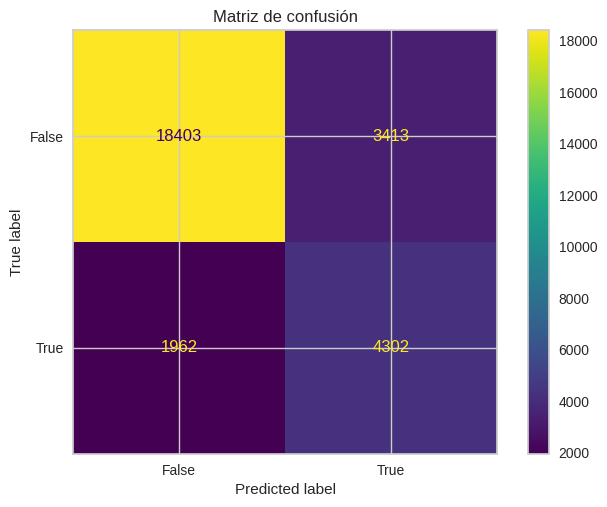

In [80]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
plt.figure(figsize=(6, 4))
disp.plot(values_format='d')
plt.title("Matriz de confusión")
plt.show()

In [81]:
print(f"Porcentaje de falsos positivos: {cm[0, 1] / (cm[0, 1] + cm[0, 0]) * 100:.4f} %")
print(f"Porcentaje de falsos negativos: {cm[1, 0] / (cm[1, 0] + cm[1, 1]) * 100:.4f} %")

Porcentaje de falsos positivos: 15.6445 %
Porcentaje de falsos negativos: 31.3218 %


### Curva ROC

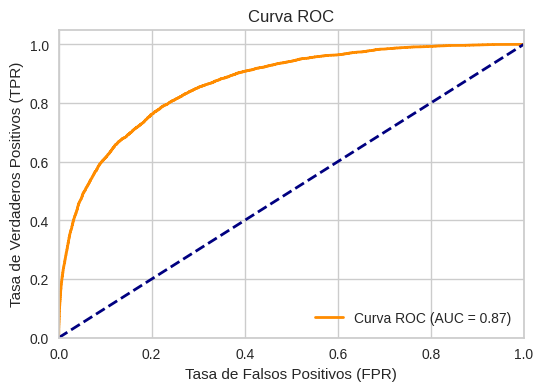

In [82]:
# Obtengo las probabilidades de predicción del modelo
y_proba_test = model2.predict_proba(X_test)[:, 1]
# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [83]:
roc_auc

0.8668802930207877

In [84]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.96672167, 0.96672167,
        1.        ]),
 array([0.00000000e+00, 1.59642401e-04, 3.35249042e-03, ...,
        9.99840358e-01, 1.00000000e+00, 1.00000000e+00]),
 array([       inf, 0.99979783, 0.99776508, ..., 0.02590068, 0.02589345,
        0.00406789]))

El modelo de regresión logística utiliza por defecto un umbral de 0.5 para clasificar. Sin embargo, este valor **no siempre es el óptimo**, especialmente si el dataset está desbalanceado o si queremos priorizar recall sobre precisión (por ejemplo, evitar falsos negativos).

A partir de la curva ROC, se podrían calcular diferentes umbrales y elegir el mejor según algún criterio, como:

- El punto que maximiza la métrica **Youden's J**: `J = Sensibilidad + Especificidad - 1`
- El punto más cercano al vértice (0, 1) de la curva ROC.
- Aquel que maximice el F1-score evaluado para distintos thresholds.


In [85]:
# Eliminar el primer valor de thresholds (inf) y sus correspondientes tpr, fpr
thresholds_clean = thresholds[1:]
tpr_clean = tpr[1:]
fpr_clean = fpr[1:]
# Calcular Youden's J
J = tpr_clean - fpr_clean
ix = np.argmax(J)
best_threshold = thresholds_clean[ix]
print(f"Mejor umbral según Youden's J: {best_threshold:.2f}")

Mejor umbral según Youden's J: 0.48


In [86]:
# Predicción usando el umbral óptimo
y_pred_opt = (y_proba_test >= best_threshold).astype(int)
# Métricas con ese umbral
print(classification_report(y_test, y_pred_opt))
print(confusion_matrix(y_test, y_pred_opt))

              precision    recall  f1-score   support

       False       0.93      0.78      0.85     21816
        True       0.50      0.79      0.62      6264

    accuracy                           0.78     28080
   macro avg       0.72      0.78      0.73     28080
weighted avg       0.83      0.78      0.79     28080

[[16964  4852]
 [ 1328  4936]]


Aunque varios modelos balanceados dieron el mismo F1-score, el que más nos sirve realmente es el que tiene mejor recall para lluvia, porque preferimos avisar de más antes que no avisar cuando realmente va a llover. Por eso, nos quedamos con el modelo que tiene class_weight='balanced', que logra detectar el 77% de las lluvias reales, lo que es un fitting bastante bueno para lo que buscamos. Tras trazar la curva ROC para nuestro modelo, encontramos un umbral que optimiza levemente el recall de la clase minoritaria a 79%.

### Modelo base basado en la clase mayoritaria

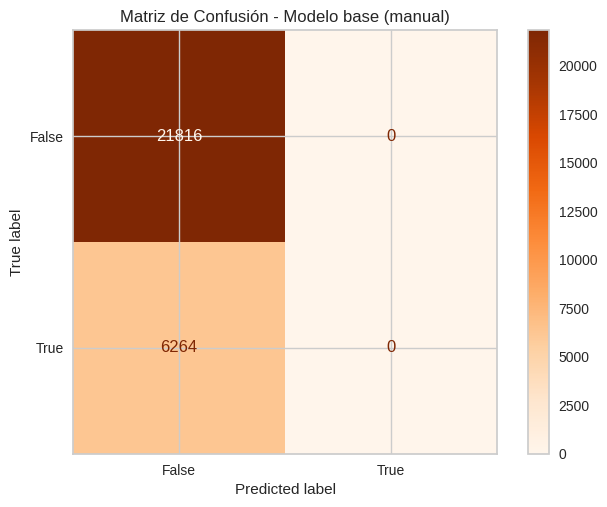

In [87]:
# Encontrar la clase más frecuente en el set de entrenamiento
clase_mayoritaria = y_train.value_counts().idxmax()

# Predecir esa clase para todo el conjunto de prueba
y_pred_base = [clase_mayoritaria] * len(y_test)

# Mostrar matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base, cmap="Oranges")
plt.title("Matriz de Confusión - Modelo base (manual)")
plt.show()

In [88]:
# Calcular y mostrar métricas
print("Reporte de métricas - Modelo base (predicción constante):")
print(classification_report(y_test, y_pred_base))

# Como no tenemos probabilidades, simulamos una probabilidad baja constante para curva ROC
# Asignamos una probabilidad 0.01 a la clase 'Yes', ya que siempre predice 'No'
y_proba_base = np.zeros(len(y_test)) + 0.01

Reporte de métricas - Modelo base (predicción constante):
              precision    recall  f1-score   support

       False       0.78      1.00      0.87     21816
        True       0.00      0.00      0.00      6264

    accuracy                           0.78     28080
   macro avg       0.39      0.50      0.44     28080
weighted avg       0.60      0.78      0.68     28080



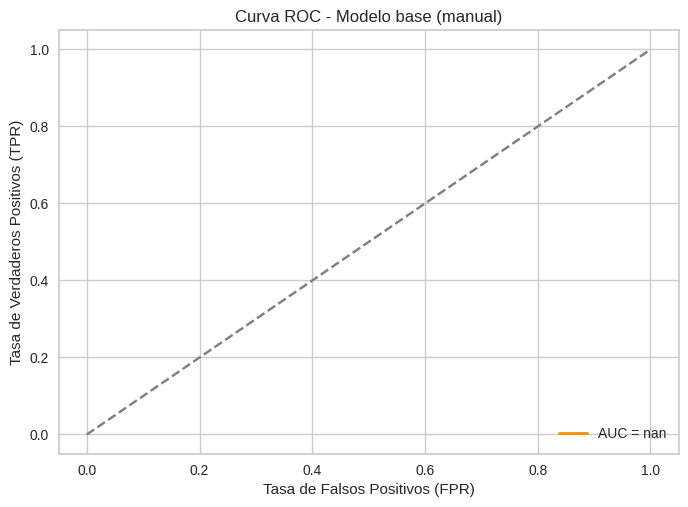

In [89]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_base, pos_label='Yes')
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Modelo base (manual)")
plt.legend(loc="lower right")
plt.show()

#### Observación sobre la curva ROC del modelo base

El modelo base implementado predice siempre la misma clase ("No"), lo que significa que no genera probabilidades diferenciadas para clasificar los casos. Como consecuencia:

- Todos los valores de probabilidad son iguales.
- No se pueden calcular tasas de verdaderos o falsos positivos para distintos umbrales.
- La **curva ROC no se puede trazar**, y el **AUC resulta `nan`** (no definido).

### Modelo base clasificador aleatorio

<Figure size 600x400 with 0 Axes>

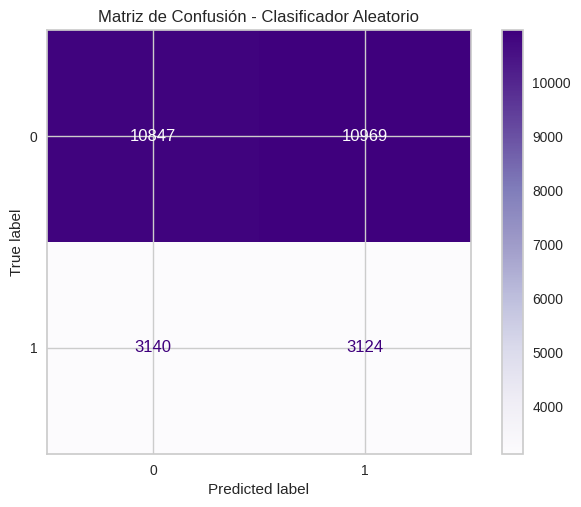

In [90]:
# Clasificador aleatorio: predice 0 o 1 al azar, sin mirar las proporciones
y_pred_random = np.random.choice([0, 1], size=len(y_test))

# Matriz de confusión
cm_2 = confusion_matrix(y_test, y_pred_random)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2)
plt.figure(figsize=(6, 4))
disp.plot(cmap="Purples", values_format='d')
plt.title("Matriz de Confusión - Clasificador Aleatorio")
plt.show()

In [91]:
# Reporte de métricas
print("Reporte de métricas - Clasificador Aleatorio:")
print(classification_report(y_test, y_pred_random))

Reporte de métricas - Clasificador Aleatorio:
              precision    recall  f1-score   support

       False       0.78      0.50      0.61     21816
        True       0.22      0.50      0.31      6264

    accuracy                           0.50     28080
   macro avg       0.50      0.50      0.46     28080
weighted avg       0.65      0.50      0.54     28080



In [92]:
print(f"Porcentaje de falsos positivos: {cm_2[0, 1] / (cm_2[0, 1] + cm_2[0, 0]) * 100:.4f} %")
print(f"Porcentaje de falsos negativos: {cm_2[1, 0] / (cm_2[1, 0] + cm_2[1, 1]) * 100:.4f} %")

Porcentaje de falsos positivos: 50.2796 %
Porcentaje de falsos negativos: 50.1277 %


# Parte 2

## Optimización de hiperparámetros


### K-Folds

Utilizamos validación cruzada K-fold como técnica de validación para evaluar el rendimiento del modelo de forma más robusta.

In [93]:
cv_scores = cross_val_score(model2, X_train, y_train, cv=5, scoring='accuracy')

print("Scores de cada fold:", cv_scores)
print("Accuracy promedio:", cv_scores.mean())

Scores de cada fold: [0.79082087 0.79429309 0.79215634 0.79058897 0.7934381 ]
Accuracy promedio: 0.7922594731754516


El modelo tiene un desempeño consistente en diferentes subconjuntos de los datos de entrenamiento.

### Grid search

In [94]:
# Parámetros a utilizar
parametros = [
  {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
  }
]

In [95]:
# Trabajaremos con una fracción del dataset para reducir el tiempo de ejecución
X_sample = X_train.sample(frac=0.25, random_state=42)
y_sample = y_train.loc[X_sample.index]

In [96]:
inicio = time.time()
# Aplicamos grid search
grid_search = GridSearchCV(
  estimator=LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42),
  param_grid=parametros,
  scoring='f1',
  cv=3,
  n_jobs=-1,
  verbose=1
)
# Entrenamos
grid_search.fit(X_sample, y_sample)

fin = time.time()
tiempo_total = fin - inicio
print(f"Tiempo de ejecución: {int(tiempo_total // 60)} min {int(tiempo_total % 60)} s")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Tiempo de ejecución: 4 min 8 s


In [97]:
print(f"Mejores parámetros obtenidos con grid search: {grid_search.best_params_}")

Mejores parámetros obtenidos con grid search: {'C': 1, 'penalty': 'l1'}


In [98]:
# Modelo ya entrenado con los mejores hiperparámetros
model_gridsearch = grid_search.best_estimator_
# Predecimos probabilidades en test
y_proba_test = model_gridsearch.predict_proba(X_test)[:, 1]
# Aplicamos el umbral óptimo
y_pred_ajustado = (y_proba_test >= best_threshold).astype(int)
# Métricas generales predicciones sobre el conjunto de test
print(classification_report(y_test, y_pred_ajustado))
# Matriz de confusión
print(confusion_matrix(y_test, y_pred_ajustado))

              precision    recall  f1-score   support

       False       0.92      0.78      0.85     21816
        True       0.50      0.78      0.61      6264

    accuracy                           0.78     28080
   macro avg       0.71      0.78      0.73     28080
weighted avg       0.83      0.78      0.79     28080

[[17026  4790]
 [ 1381  4883]]


En comparación con nuestro modelo anterior, este presenta métricas generales similares, pero un ligero aumento en la cantidad de falsos positivos. Entonces, por ahora, decidimos mantener el modelo previamente seleccionado.

### Random Search

In [99]:
# Parámetros a utilizar
parametros = [
  {
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 200]
  },
  {
    'solver': ['lbfgs', 'sag', 'newton-cg'],
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 200]
  },
  {
    'solver': ['saga'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.0, 0.5, 1.0],  # solo tiene efecto con elasticnet
    'max_iter': [100, 200]
  }
]

In [100]:
inicio = time.time()
#Aplicamos random search
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(class_weight='balanced', random_state=42),
    param_distributions=parametros,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
)
# Entrenamos
random_search.fit(X_sample, y_sample)

fin = time.time()
tiempo_total = fin - inicio
print(f"Tiempo de ejecución: {int(tiempo_total // 60)} min {int(tiempo_total % 60)} s")

Tiempo de ejecución: 1 min 35 s


In [101]:
print(f"Mejores parámetros obtenidos con random search: {random_search.best_params_}")

Mejores parámetros obtenidos con random search: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 200, 'C': 1}


In [102]:
# Modelo ya entrenado con los mejores hiperparámetros
model_randomsearch = random_search.best_estimator_
# Predecimos probabilidades en test
y_proba_test = model_randomsearch.predict_proba(X_test)[:, 1]
# Aplicamos el umbral óptimo
y_pred_ajustado = (y_proba_test >= best_threshold).astype(int)
# Métricas generales predicciones sobre el conjunto de test
print(classification_report(y_test, y_pred_ajustado))
# Matriz de confusión
print(confusion_matrix(y_test, y_pred_ajustado))

              precision    recall  f1-score   support

       False       0.92      0.78      0.85     21816
        True       0.50      0.78      0.61      6264

    accuracy                           0.78     28080
   macro avg       0.71      0.78      0.73     28080
weighted avg       0.83      0.78      0.79     28080

[[17026  4790]
 [ 1381  4883]]


El modelo con el umbral ajustado por ROC (segundo) tiene un recall y F1-score ligeramente superiores para la clase True, por lo que continuamos prefiriéndolo por sobre el obtenido por random search.

### Optuna

Decidimos también aplicar este método para comparar con Grid y Random Search.

In [103]:
valid_solver_penalty = [
  "liblinear|l1", "liblinear|l2",
  "lbfgs|l2", "lbfgs|None",
  "newton-cg|l2", "newton-cg|None",
  "sag|l2", "sag|None",
  "saga|l1", "saga|l2", "saga|elasticnet", "saga|None"
]

In [104]:
def objective(trial):
  # Elegir combinación válida
  solver_penalty = trial.suggest_categorical("solver_penalty", valid_solver_penalty)
  solver, penalty = solver_penalty.split("|")
  if penalty == "None":
    penalty = None

  C = trial.suggest_float("C", 1e-2, 1e2, log=True)
  max_iter = trial.suggest_int("max_iter", 100, 500)

  params = {
    "solver": solver,
    "penalty": penalty,
    "C": C,
    "max_iter": max_iter,
    "class_weight": "balanced",
    "random_state": 42
    }

  if penalty == "elasticnet":
    params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)

  try:
    model = LogisticRegression(**params)
    scores = cross_val_score(model, X_sample, y_sample, scoring='f1', cv=3, n_jobs=-1)
    return scores.mean()
  except Exception:
    return 0.0  # Penalizar combinaciones inválidas

In [133]:
inicio = time.time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

fin = time.time()
tiempo_total = fin - inicio
print(f"Tiempo de ejecución: {int(tiempo_total // 60)} min {int(tiempo_total % 60)} s")

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-02 19:01:29,530] Trial 0 finished with value: 0.5983191618605668 and parameters: {'solver_penalty': 'saga|None', 'C': 0.013781827558780296, 'max_iter': 153}. Best is trial 0 with value: 0.5983191618605668.
[I 2025-06-02 19:01:32,121] Trial 1 finished with value: 0.6250423540762711 and parameters: {'solver_penalty': 'lbfgs|None', 'C': 24.931226011759346, 'max_iter': 207}. Best is trial 1 with value: 0.6250423540762711.
[I 2025-06-02 19:01:40,388] Trial 2 finished with value: 0.6008029256422709 and parameters: {'solver_penalty': 'sag|l2', 'C': 4.191208947659859, 'max_iter': 130}. Best is trial 1 with value: 0.6250423540762711.
[I 2025-06-02 19:01:51,171] Trial 3 finished with value: 0.6017140812782644 and parameters: {'solver_penalty': 'sag|l2', 'C': 0.5171023263488789, 'max_iter': 151}. Best is trial 1 with value: 0.6250423540762711.
[I 2025-06-02 19:01:53,952] Trial 4 finished with value: 0.625428454574775 and parameters: {'solver_penalty': 'lbfgs|l2', 'C': 2.493097115590486

In [134]:
print(f"Mejores parámetros obtenidos con optuna: {study.best_params}")

Mejores parámetros obtenidos con optuna: {'solver_penalty': 'newton-cg|None', 'C': 59.59930273447722, 'max_iter': 139}


In [135]:
# Obtener y procesar los mejores parámetros encontrados por Optuna
best_params = study.best_params
# Separar el string 'solver_penalty'
solver, penalty = best_params['solver_penalty'].split('|')
if penalty == "None":
    penalty = None
# Crear el diccionario de parámetros finales
final_params = {
    'solver': solver,
    'penalty': penalty,
    'C': best_params['C'],
    'max_iter': best_params['max_iter'],
    'class_weight': 'balanced',
    'random_state': 42
}
# Incluir l1_ratio solo si corresponde
if 'l1_ratio' in best_params:
    final_params['l1_ratio'] = best_params['l1_ratio']
# Entrenar el modelo con los mejores parámetros
model_optuna = LogisticRegression(**final_params)
model_optuna.fit(X_train, y_train)
# Predecimos probabilidades en test
y_proba_test = model_optuna.predict_proba(X_test)[:, 1]
# Aplicamos el umbral óptimo
y_pred_ajustado = (y_proba_test >= best_threshold).astype(int)
# Métricas generales predicciones sobre el conjunto de test
print(classification_report(y_test, y_pred_ajustado))
# Matriz de confusión
print(confusion_matrix(y_test, y_pred_ajustado))

              precision    recall  f1-score   support

       False       0.93      0.78      0.85     21816
        True       0.50      0.79      0.62      6264

    accuracy                           0.78     28080
   macro avg       0.72      0.78      0.73     28080
weighted avg       0.83      0.78      0.79     28080

[[16960  4856]
 [ 1326  4938]]


Comparando los métodos utilizados, las métricas obtenidas entre los hiperparámetros seleccionados son casi idénticas entre sí. Utilizando Optuna, encontramos un modelo que igualó a nuestro modelo previo pero no logramos superarlo. Concluimos que, en este caso, random search es la mejor opción ya que logra los mismos resultados a cambio de un coste computacional mucho menor. De todas modos, podemos decir que Optuna ofrece una ventaja importante al permitir un control más fino sobre la búsqueda y evitar combinaciones inválidas.

## SHAP

In [108]:
# Crea un objeto explainer SHAP
feature_names = X_train.columns.values
explainer = shap.LinearExplainer(model1, X_train, feature_names=feature_names)

In [109]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test)

### Interpretabilidad **local**

Analizaremos localmente los dos casos extremos: aquel en el que el modelo predijo con mayor probabilidad que lloverá, y aquel en el que predijo con mayor certeza que no lloverá.

In [110]:
# Obtener probabilidades de que llueva mañana (clase 1)
probabilidades = model1.predict_proba(X_test)[:, 1]
# Identificar índice con mayor y menor probabilidad
indice_mayor_prob = probabilidades.argmax()
indice_menor_prob = probabilidades.argmin()

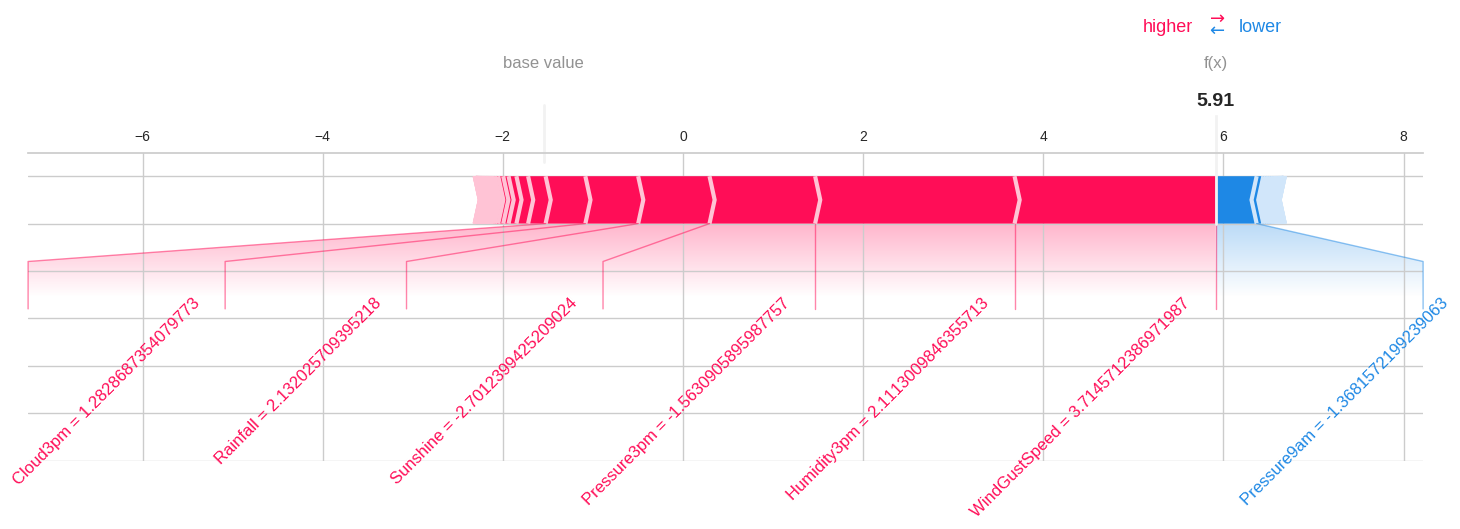

In [111]:
# Caso 1: Mayor probabilidad de lluvia al día siguiente
index = indice_mayor_prob
shap.force_plot(explainer.expected_value, shap_values[index], X_test.iloc[index],
                feature_names=feature_names, matplotlib=True, figsize=(18, 4),
                text_rotation=45)

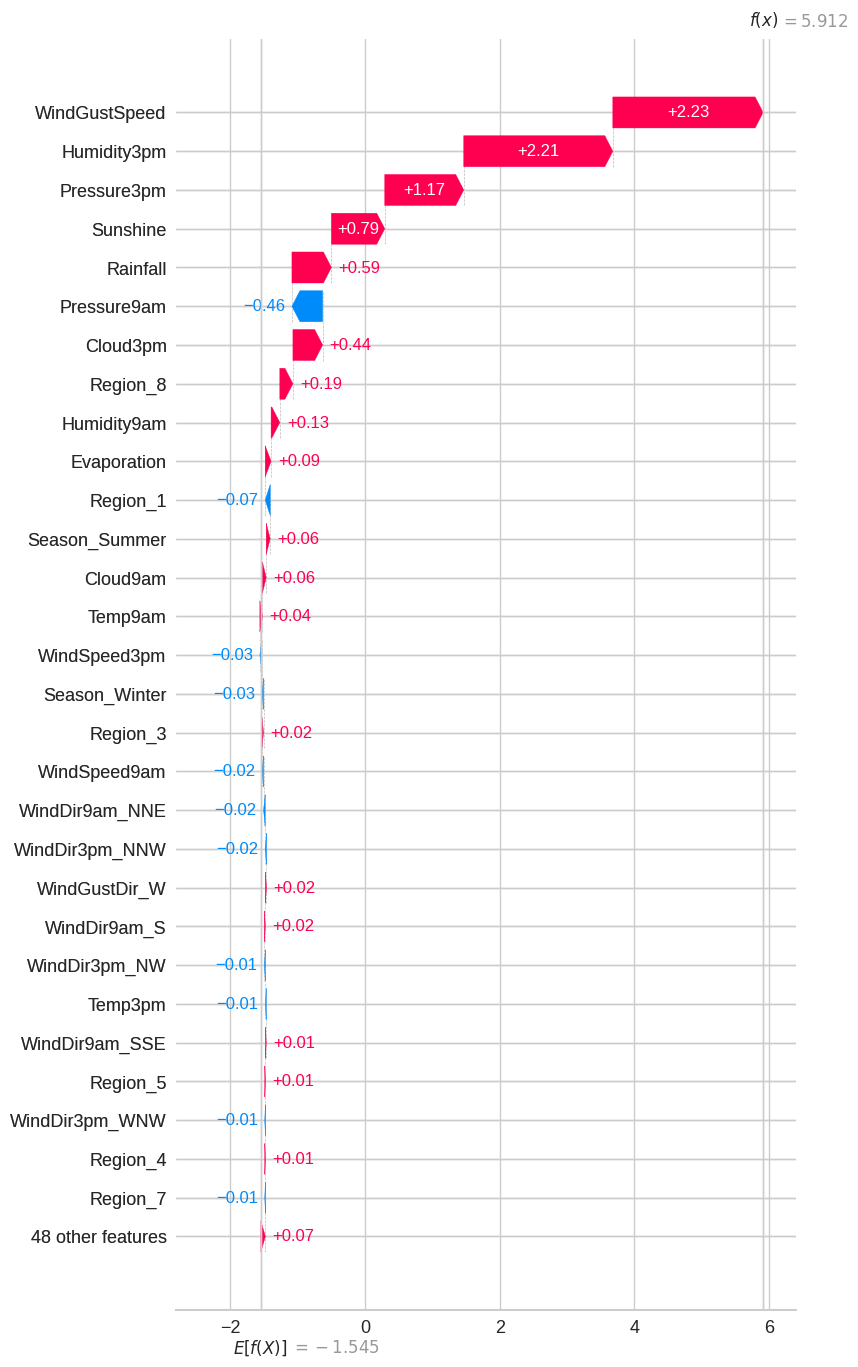

In [112]:
explanation = shap.Explanation(values=shap_values[index],
                               base_values=explainer.expected_value,
                               feature_names=feature_names)
shap.plots.waterfall(explanation, max_display=30)

Se observa que las variables que mas peso tuvieron son WindGustSpeed, Humidity3pm, Pressure3pm y Sunshine para la predicción de que al día siguiente iba a llover.

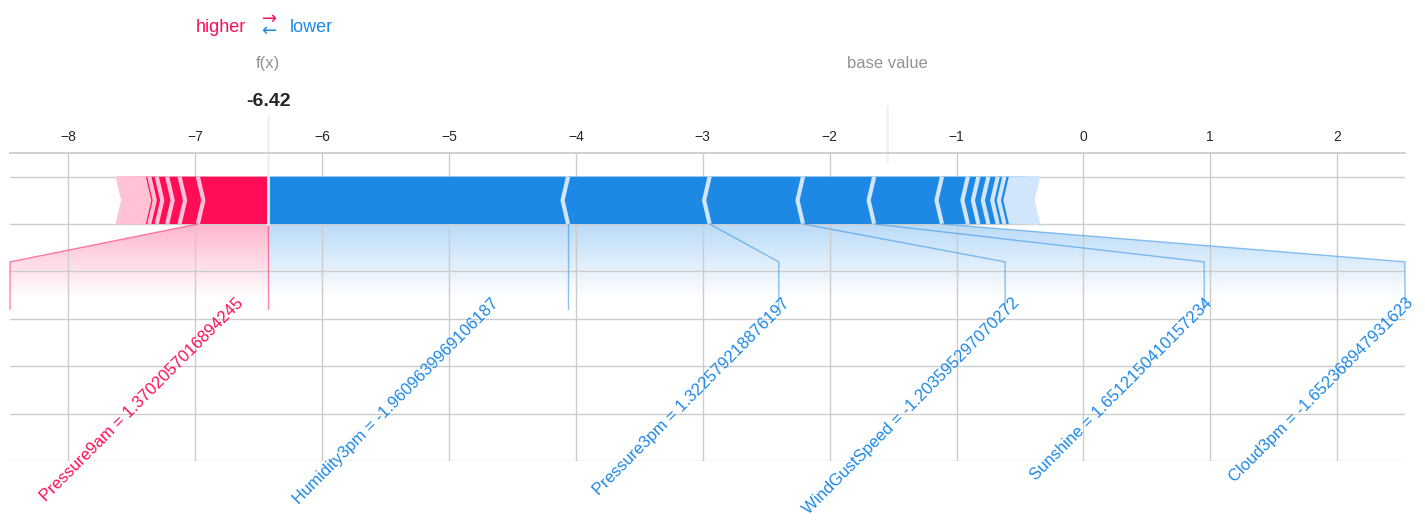

In [113]:
# Caso 2: Mayor probabilidad de que NO llueve al día siguiente
index = indice_menor_prob
shap.force_plot(explainer.expected_value, shap_values[index], X_test.iloc[index],
                feature_names=feature_names, matplotlib=True, figsize=(18, 4),
                text_rotation=45)

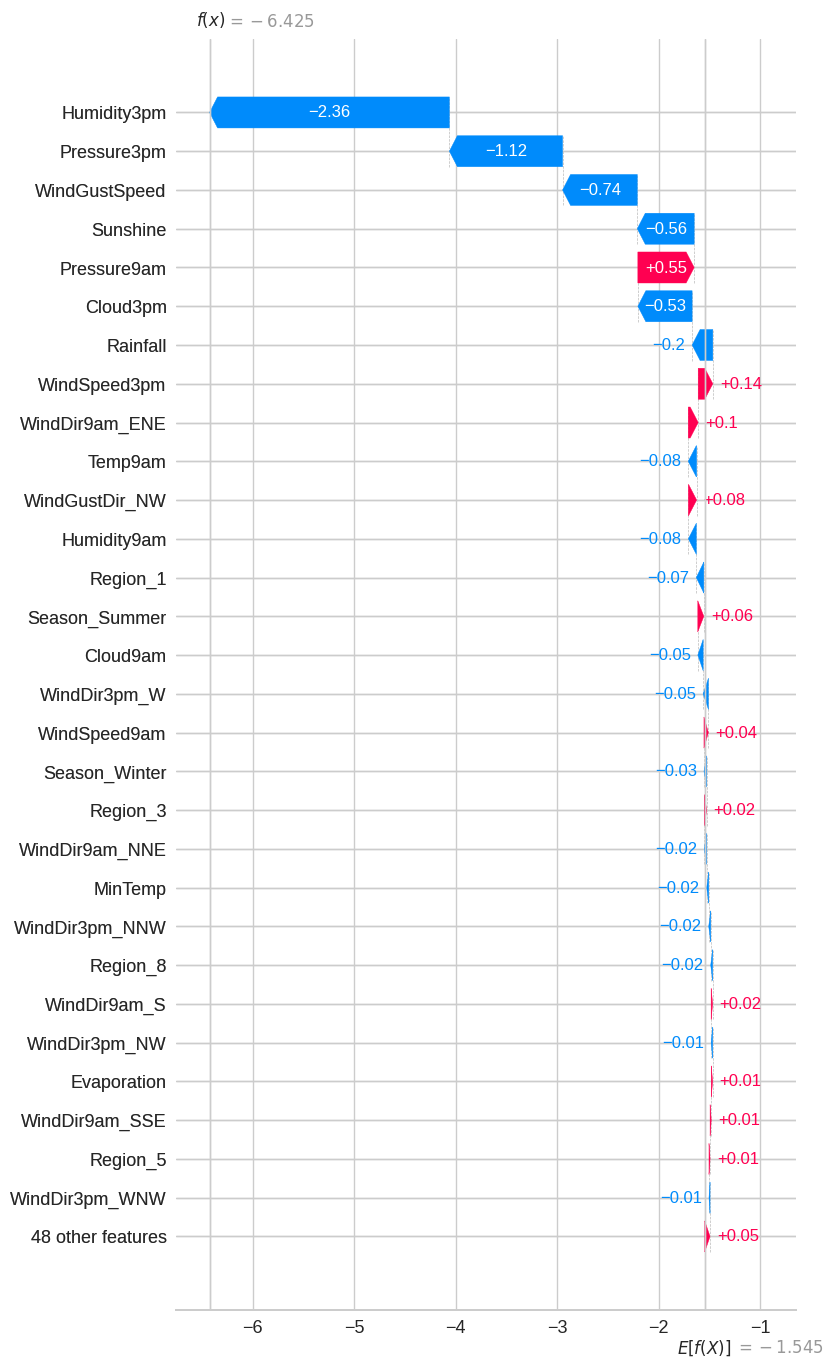

In [114]:
explanation = shap.Explanation(values=shap_values[index],
                               base_values=explainer.expected_value,
                               feature_names=feature_names)
shap.plots.waterfall(explanation, max_display=30)

Para el caso contrario, probabilidad alta de que no lloverá al día siguiente, las variables con mayor peso en la predicción fueron las mismas: Humidity3pm, WindGustSpeed, Pressure3pm y Sunshine. Sin embargo, se observa una diferencia significativa en los valores individuales de estas variables en comparación con el caso en que sí se predijo lluvia. Se puede observar como un conjunto de variables puede tener una influencia distinta en cada predicción dependiendo de sus valores.

### Interpretabilidad **global**

Variables mas consideradas por nuestro modelo teniendo en cuenta el conjunto de test completo.

In [115]:
base_values = np.full((shap_values.shape[0],), explainer.expected_value)

In [116]:
shap_values = np.array(shap_values, dtype=np.float64)
base_values = np.array(base_values, dtype=np.float64)
X_test_array = np.array(X_test, dtype=np.float64)

In [117]:
global_explanation = shap.Explanation(values=shap_values, base_values=base_values, feature_names=feature_names, data=X_test_array)

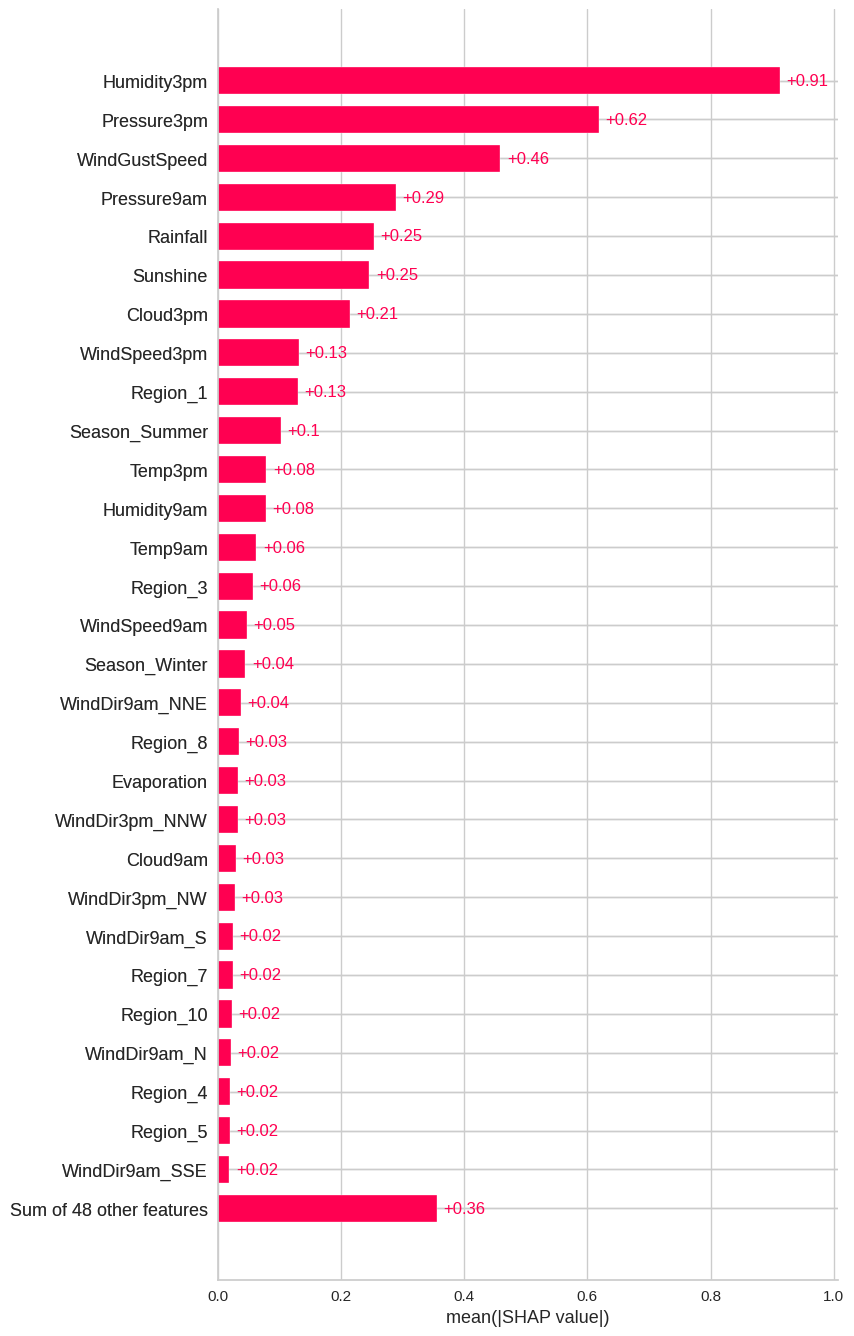

In [118]:
shap.plots.bar(global_explanation, max_display=30)

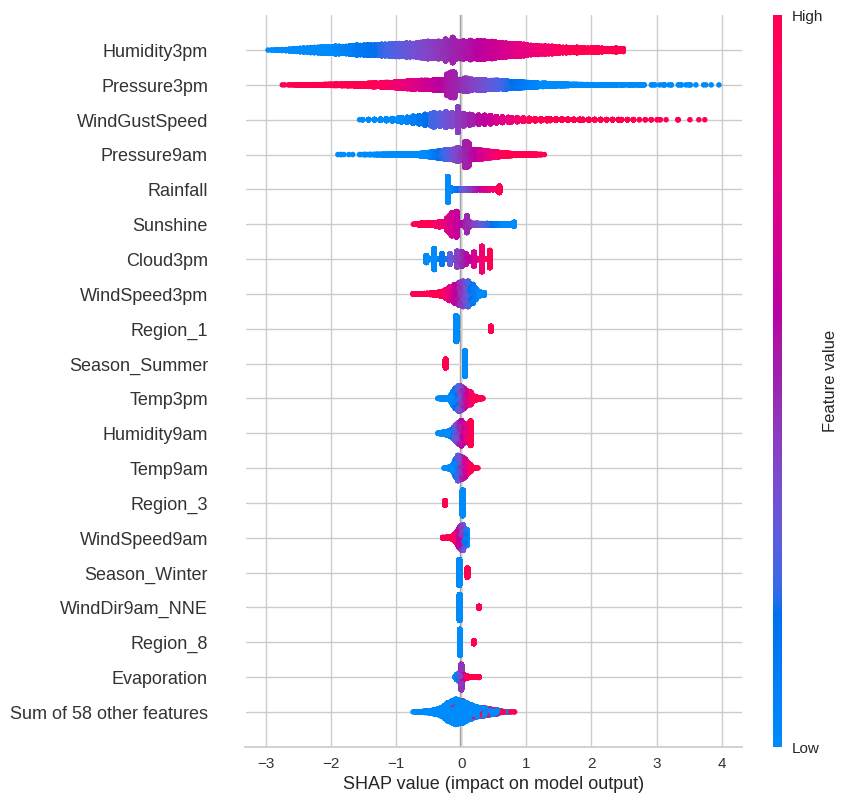

In [119]:
shap.plots.beeswarm(global_explanation, max_display = 20)

## AutoML

In [121]:
train_df.head(10) #al final use el dataset escalado

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,Season_Spring,Season_Summer,Season_Winter,RainTomorrow
94054,1.985336,1.204149,-0.570659,-0.004288,0.049512,0.082694,-0.115057,0.157183,0.009004,0.559962,...,False,False,False,False,False,False,False,True,False,True
73203,-0.544614,0.093366,-0.232823,0.312038,0.362888,-0.219962,0.676775,-0.186009,-0.674452,-1.282253,...,False,False,False,False,False,False,False,True,False,False
55168,0.439255,1.372876,-0.570659,0.588714,-0.437963,-0.068634,-1.359364,0.157183,-2.199084,-1.039856,...,False,False,True,False,False,False,False,True,False,False
113203,0.064448,-0.778388,1.625272,-0.054561,0.397708,0.461015,-0.115057,-0.643597,-0.516731,0.753879,...,False,False,False,False,True,False,False,False,True,True
121553,1.017083,2.216508,-0.570659,1.774716,1.581576,0.082694,0.111181,-1.329979,-1.410481,-1.233774,...,False,False,False,False,False,False,False,True,False,False
128040,-0.154190,-0.258147,-0.570659,-0.054561,0.397708,-0.673947,-1.585601,-1.101185,1.113048,1.093235,...,False,False,False,False,False,False,False,False,False,False
91463,0.392404,0.262093,-0.570659,0.051080,0.536987,-1.354923,-0.793770,0.042786,-0.464158,0.026689,...,False,False,False,False,False,False,False,False,False,False
65704,-1.341080,-1.158022,-0.570659,-1.082472,-2.387863,-1.203595,-0.567532,-1.101185,0.797607,0.220607,...,False,False,False,False,False,False,False,False,False,False
44235,0.579808,1.485360,-0.570659,0.030087,0.084331,2.730938,2.826033,1.644345,-1.778496,-1.912485,...,False,False,False,False,True,False,True,False,False,True
115274,-0.044871,0.866696,-0.570659,-0.054561,1.442297,-0.068634,0.337419,0.614771,-2.461952,-1.815526,...,False,False,True,False,False,False,True,False,False,False


Inicializamos el entorno de PyCaret para un problema de clasificación utilizando los conjuntos de train y test que contienen la variable target.

In [123]:
clf = setup(data=train_df, target='RainTomorrow', session_id=42, fix_imbalance=True)

,Description,Value
0,Session id,42
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(112318, 78)"
4,Transformed data shape,"(155698, 78)"
5,Transformed train set shape,"(122002, 78)"
6,Transformed test set shape,"(33696, 78)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


In [124]:
inicio = time.time()
# Entrena y compara modelos para obtener el mejor en base a su f1 score.
best_model = compare_models(sort='F1')

fin = time.time()
tiempo_total = fin - inicio
print(f"Tiempo de ejecución: {int(tiempo_total // 60)} min {int(tiempo_total % 60)} s")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8466,0.8848,0.6519,0.6598,0.6558,0.5572,0.5572,36.8560
xgboost,Extreme Gradient Boosting,0.8538,0.8836,0.5890,0.7096,0.6436,0.5527,0.5565,5.5180
lightgbm,Light Gradient Boosting Machine,0.8506,0.8808,0.5923,0.6958,0.6399,0.5464,0.5493,17.4130
et,Extra Trees Classifier,0.8495,0.8803,0.5884,0.6937,0.6367,0.5426,0.5455,37.6220
gbc,Gradient Boosting Classifier,0.8193,0.8696,0.7042,0.5798,0.6359,0.5172,0.5216,62.7480
lr,Logistic Regression,0.8253,0.8425,0.6126,0.6098,0.6112,0.4985,0.4985,26.3990
ada,Ada Boost Classifier,0.7970,0.8500,0.7069,0.5358,0.6095,0.4759,0.4842,15.1310
ridge,Ridge Classifier,0.8307,0.8496,0.5870,0.6316,0.6085,0.5006,0.5012,2.7330
lda,Linear Discriminant Analysis,0.8307,0.8495,0.5868,0.6316,0.6084,0.5005,0.5011,4.2550
knn,K Neighbors Classifier,0.8078,0.8237,0.6420,0.5624,0.5995,0.4738,0.4756,17.0090


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Tiempo de ejecución: 44 min 29 s


AutoML comparó una amplia variedad de modelos como Random Forest, XGBoost, LightGBM, Extra Trees, Gradient Boosting, Logistic Regression, Ridge, SVM, KNN, Naive Bayes, etc.

El proceso completo de AutoML demoró 44 minutos, lo cual consideramos computacionalmente costoso. Sin embargo, es justificado por la automatización del preprocesamiento, entrenamiento, evaluación y comparación sistemática de más de 15 modelos distintos, permitiendo identificar rápidamente las mejores alternativas sin intervención manual.

In [125]:
best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Tras evaluar métricas como accuracy, AUC, precision, recall, F1-score, Kappa y MCC, el sistema seleccionó al Random Forest Classifier como el mejor modelo por su:

* Mayor F1-score (0.6558), lo que indica un buen balance entre precisión y recall.
* Alta AUC (0.8848), lo que refleja una excelente capacidad de discriminación entre clases.

* Buen desempeño general tanto en la clase mayoritaria como en la minoritaria.

In [132]:
# Hacer predicciones sobre los datos de prueba
predictions = predict_model(best_model, data=test_df)
y_pred = predictions['prediction_label']
# Métricas generales predicciones sobre el conjunto de test
print(classification_report(test_df["RainTomorrow"], y_pred))
# Matriz de confusión
print(confusion_matrix(test_df["RainTomorrow"], y_pred))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8468,0.8839,0.6443,0.6606,0.6523,0.5541,0.5542


              precision    recall  f1-score   support

       False       0.90      0.90      0.90     21816
        True       0.66      0.64      0.65      6264

    accuracy                           0.85     28080
   macro avg       0.78      0.77      0.78     28080
weighted avg       0.85      0.85      0.85     28080

[[19742  2074]
 [ 2228  4036]]


Al comparar este modelo con los que entrenamos anteriormente (como el modelo optimizado con Optuna y ajuste de umbral óptimo a partir de la curva ROC), observamos que:

AutoML con Random Forest logra un mayor F1-score para la clase minoritaria (0.65 frente a 0.62), lo cual indica una mejora en el equilibrio entre precision y recall.

Sin embargo, nuestros modelos anteriores obtuvieron un mayor recall para la clase minoritaria (0.79 frente a 0.65), lo que implica que son más efectivo para detectar correctamente los casos positivos (lluvia), a costa de una menor precisión.